# Price Dynamics Analysis

## CAISO Day-ahead electricity market

### Using individual RandomForest and XGBoost models

- Data preprocessing
- Exploratory data analysis
- Train-test split
- Forecast
  - RandomForest, XGBoost
 
RandomForest and XGBoost
- Basic
- Feature Engineered + Hypertuned
- ARIMA + GARCH with volatility

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import warnings

from scipy.stats import skew, kurtosis, boxcox, zscore
from scipy.stats.mstats import winsorize

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

Set specifics for visuals

In [5]:
palette = "Dark2"

plt.rc("figure", figsize=(16,8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=20)
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="small", titleweight="bold", titlesize=20, titlepad=15)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings('ignore')
plt.close('all')

sns.set(style="whitegrid", palette=palette, font_scale=1.8)
figpath = "../Figures/"

Define paths and other input parameters

In [7]:
pacific_tz = "America/Los_Angeles"

file_path = '../Data/CAISO/'
file_name = 'caiso_lmp_da_hr_zones_*.csv' 

areas = ['ZP-26']

columns_to_keep = [
    "UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)",
    "ZP-26 LMP"
]

split_date = '2025-02-25 00:00:00'
test_end = '2025-03-04 00:00:00'
time_delta = 1

best_arima_order = (1,0,1) 
best_garch_order = (1,1)

Keep user-defined functions here

In [9]:
def set_index(df, time_col="UTC_Ending"):
    if time_col not in df.columns:
        raise ValueError("Invalid time column selection. Choose 'UTC_Ending' or 'Local_Ending'")
    return df.set_index(time_col)

def impute_hourly_avg(df, cols):
    
    for col in cols:
        for idx in df[df[col].isna()].index:
            prev_day = idx - pd.Timedelta(days=1)
            next_day = idx + pd.Timedelta(days=1)
            prev2_day = idx - pd.Timedelta(days=2) 
            
            values = []
            
            if prev_day in df.index and not pd.isna(df.loc[prev_day, col]):
                values.append(df.loc[prev_day, col])
            if next_day in df.index and not pd.isna(df.loc[next_day, col]):
                values.append(df.loc[next_day, col])
                
            # if insufficient values, check two days before
            
            if len(values)<2:
                if prev2_day in df.index and not pd.isna(df.loc[prev2_day, col]):
                    values.append(df.loc[prev2_day, col])
            
            
            if values:
                df.loc[idx, col] = sum(values)/len(values)
                
    return df

def plot_time_series(df, areas, time_col="Local_Ending", name='Original'):
    df = set_index(df, time_col)
    
    plt.figure(figsize=(12,6))
    for col in areas:
        plt.plot(df[col], label=col, linewidth=1)
    plt.legend()
    plt.title("Time series of LMPs")
    plt.xlabel("Time")
    plt.ylabel("LMP")
    plt.savefig(figpath + "TS_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def plot_ts(df, price_areas, areas, time_col="Local_Ending", name='Original'):
    df = set_index(df, time_col)
    
    for i in range(len(price_areas)):
        col = price_areas[i]
        area = areas[i]
    
        plt.figure(figsize=(12,6))
        plt.plot(df[col], label=area, linewidth=0.5, alpha=0.5)
        plt.plot(df[col].rolling(window=24).mean(), label=f"Rolling Mean {area}", linewidth=1)
        plt.legend()
        plt.title(f"Time series of LMPs for {area}")
        plt.xlabel("Time")
        plt.ylabel("LMP ($/MWh)")
        plt.savefig(figpath + "TS_RollMean_" + area + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def scatterplots(df, areas, time_col="Local_Ending", name='Original'):
    df = set_index(df, time_col)
    
    pairs = [(areas[i], areas[(i+1) % len(areas)]) for i in range(len(areas))]
    
    for pair in pairs:
        plt.figure(figsize=(8,6))
        plt.scatter(df[pair[0]], df[pair[1]], alpha=0.5)
        plt.xlabel(pair[0])
        plt.ylabel(pair[1])
        plt.savefig(figpath + "Scatter_" + pair[0] + "_" + pair[1] + name + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def analyze_trends(df, time_col="UTC_Ending"):
    df = set_index(df, time_col)
    df["Hour"] = df.index.hour
    df["Day"] = df.index.date
    print(df.head())
    
    hourly_avg = df.groupby("Hour")[area_lmp].mean()
    print("\nHourly Average LMP:")
    print(hourly_avg)
    
    daily_avg = df.groupby("Day")[area_lmp].mean()
    print("\nDaily Average LMP:")
    print(daily_avg)
    
    return hourly_avg, daily_avg

def compute_statistics(df, area_lmp):
    stats = df[area_lmp].describe().T
    stats["skewness"] = df[area_lmp].apply(skew)
    stats["kurtosis"] = df[area_lmp].apply(kurtosis)
    
    print("\nBasic statistics:")
    print(stats)
    
    return stats

def plot_distrib(df, area_lmp, name='Original'):
    
    area_pairs = [(area_lmp[i], area_lmp[j]) for i in range(len(area_lmp)) for j in range(i+1, len(area_lmp))] 
    
    fig, axes = plt.subplots(1, len(area_pairs), figsize=(20,5))
    
    for ax, (area1, area2) in zip(axes, area_pairs):
        sns.kdeplot(df[area1], label=area1, ax=ax, fill=True, alpha=0.5)
        sns.kdeplot(df[area2], label=area2, ax=ax, fill=True, alpha=0.5)
        ax.set_title(f'{area1} vs {area2}')
        ax.set_xlabel('LMP values')
        ax.legend(fontsize="xx-small", loc=4)
        
        inset_ax = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
        sns.scatterplot(x=df[f'{area1}'], y=df[f'{area2}'], alpha=0.3, ax=inset_ax)
        inset_ax.set_xlabel(area1, fontsize="xx-small")
        inset_ax.set_ylabel(area2, fontsize="xx-small")
        
    plt.tight_layout()
    plt.savefig(figpath + "Distrib_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def plot_diurnals(df, area_lmp, name='Original'):
    
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    
    fig, axes = plt.subplots(3,4, figsize=(20,15), sharex=True, sharey=True)
    
    for month in range(1,13):
        ax = axes[(month-1)//4, (month-1)%4]
        
        for area in area_lmp:
            monthly_data = df[df['month']==month].groupby('hour')[area].mean()
            ax.plot(monthly_data.index, monthly_data.values, label=area)
            
        ax.set_title(f'Month {month}')
        ax.set_xlabel('Hour of the day')
        ax.set_ylabel('Average LMP')
        ax.legend()
        
    plt.tight_layout()
    plt.savefig(figpath + "Diurnal_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
        
    return

def plot_boxplots(df, area_lmp, name='Original'):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[area_lmp])
    plt.title("Box plot of LMPs")
    plt.savefig(figpath + "Boxplot_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def plot_load_durations(df, cols, name='Original'):
    plt.figure(figsize=(10,6))
    
    for col in cols:
        sorted_values = df[col].sort_values(ascending=False).reset_index(drop=True)
        plt.plot(sorted_values, label=col)
        
    plt.xlabel("Hours (sorted by LMP)")
    plt.ylabel("LMP ($/MWh)")
    plt.title("Load duration curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(figpath + "LD_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    return

def remove_outliers_iqr(df, cols):
    
    '''
    Outlier removal using Interquartile range to clip extreme values that are beyond 1.5 times the IQR. 
    Note: no data loss occurs.
    '''
    
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(col, Q1, Q3, IQR, lower_bound, upper_bound)
        
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound) #df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
    
def winsorize_outliers(df, cols, limits=(0.01, 0.01)):
    '''
    Winsorization is an excellent way to remove outliers while preserving data integrity. Instead of
    removing them, it replaces extreme values with the nearest percentile-based threshold. Usually, the
    1st percentile (low end) and 99th percentile (high end) are used.
    '''
    
    for col in cols:
        df[col] = winsorize(df[col], limits=limits)
        
    return df

def get_timecols(df):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    return df

def get_ext_timecols(df):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    #df['weekofyear'] = df.index.isocalendar().week
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df
    
def get_train_test(df, split_date, test_end, time_delta):
    
    new_split = pd.to_datetime(split_date) - pd.Timedelta(days=time_delta)

    df_train = df[df.index < new_split].copy()
    df_test = df[(df.index >= new_split) & (df.index <= test_end)].copy()
    
    return df_train, df_test

def comparative_plot1(df_test, area, actual_values, prediction, var1='Actual values', var2='Forecast', name='Model'):
    
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df_test.index, prediction, lw=2, label=var2)
    ax.plot(df_test.index, actual_values, lw=2, linestyle='--', label=var1)
    ax.legend(loc='lower left', fontsize=30)
    ax.set_title(f'Forecast vs Actual for {area}', fontsize=40)
    ax.set_ylabel('LMP ($/MWh)', fontsize=30)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=30)
    
    inset_ax = inset_axes(ax, width='25%', height='35%', loc='upper right')
    inset_ax.scatter(actual_values, prediction, alpha=0.5)
    inset_ax.set_xlabel('Actual', fontsize=30)
    inset_ax.set_ylabel('Predicted', fontsize=30)
    inset_ax.tick_params(axis='both', labelsize=30)
    
    plt.tight_layout()
    plt.savefig(figpath + "Forecast_" + area + "_" + var2 + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def comparative_plot2(df_test, area, actual_values, prediction_rf, prediction_gb, var1='Actual values', var2='Forecast1', var3='Forecast3', name='Model'):
    
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df_test.index, prediction_rf, lw=2, label=var2)
    ax.plot(df_test.index, prediction_gb, lw=2, label=var3)
    ax.plot(df_test.index, actual_values, lw=2, linestyle='--', label=var1)
    ax.legend(loc='lower left', fontsize=30)
    ax.set_title(f'Forecast vs Actual for {area}', fontsize=40)
    ax.set_ylabel('LMP ($/MWh)', fontsize=30)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=30)
    
    inset_ax = inset_axes(ax, width='25%', height='35%', loc='upper right')
    inset_ax.scatter(actual_values, prediction_rf, alpha=0.5, label=var2)
    inset_ax.scatter(actual_values, prediction_gb, alpha=0.5, label=var3)
    inset_ax.set_xlabel('Actual', fontsize=30)
    inset_ax.set_ylabel('Predicted', fontsize=30)
    inset_ax.tick_params(axis='both', labelsize=30)
    inset_ax.legend(fontsize=30)
    
    plt.tight_layout()
    plt.savefig(figpath + "Forecast_" + area + "_" + var2 + "_" + var3 + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def check_stationarity(series):
    
    result = adfuller(series.dropna())
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] <= 0.05:
        print("Reject the null hypothesis: Time series is stationary")
    else:
        print("Fail to reject the null hypothesis: Time series is non-stationary")
        
    return 

def pacf_display(returns, area):
    
    fig, ax = plt.subplots(2,1, figsize=(20, 12), sharex=True)
    
    smt.graphics.plot_acf(returns, zero=False, ax=ax[0], auto_ylims=True, alpha=0.5)
    smt.graphics.plot_pacf(returns, zero=False, ax=ax[1], auto_ylims=True, alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(figpath + "ACF_PACF_" + area + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def transform_series(series):
     
    min_val = series.min()
    shift_val = abs(min_val) + 0.01 if min_val <= 0 else 0
    
    transformed_series = np.log(series + shift_val)
    return transformed_series

def vis_returns(returns, vol, area, name, var1='Returns', var2='Volatility'):
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(f'LMP {var1} & {var2} of {area}')
    
    ax1.plot(returns)
    ax1.set_ylabel(var1)
    
    ax2.plot(vol)
    ax2.set_ylabel(var2)
    plt.tight_layout()
    plt.savefig(figpath + "Returns_overview_" + area + "_" + name + ".png", bbox_inches="tight", pad_inches=0.3)
    
    return

def best_ARIMA_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    d_values = range(0,2)
    q_values = range(0,3)
    
    for order in product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue
            
    return best_order

def best_GARCH_order(series):
    
    best_aic = np.inf
    best_order = None
    
    p_values = range(0,3)
    q_values = range(0,3)
    
    for p, q in product(p_values, q_values):
        try:
            model = arch_model(series, mean='Zero', vol='Garch', p=p, q=q).fit(disp='off')
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, q)
        except:
            continue
            
    return best_order

def get_res_vol(df, area, best_arima_order, best_garch_order):
        
    ser = transform_series(df[area])
    ret = ser.diff().dropna()
        
    arima_model = ARIMA(ret, order=best_arima_order).fit()  
    arima = arima_model.resid.values
        
    lst_arima = arima.tolist()
    lst_arima.insert(0, np.nan)
        
    garch_model = arch_model(arima, mean='Zero', vol='Garch', p=best_garch_order[0], q=best_garch_order[1]).fit(disp='off')
    vol = garch_model.conditional_volatility
    
    lst_vol = vol.tolist()
    lst_vol.insert(0, np.nan)
        
    return lst_arima, lst_vol

### Reading input data

Read input files and combine multiple years

- sort the input files to maintain chronology
- rename the time columns

### Data preprocessing

Get an overview on data quality (preprocessing):

- check for missing timestamp
- check for missing values (NaN), should be none at the end
- check for negative values

Make sure to

- ensure local timestamps are time-zone aware
- final dataframe is saved in a csv file

In [11]:
files = sorted(glob.glob(file_path + file_name)) 

df_list=[]

for file in files:
    temp_df = pd.read_csv(file, skiprows=3, usecols=columns_to_keep, parse_dates=["UTC Timestamp (Interval Ending)", "Local Timestamp Pacific Time (Interval Ending)"], index_col=False)
    
    df_list.append(temp_df)
    
orig_df = pd.concat(df_list, ignore_index=True)

orig_df.rename(columns={
    "UTC Timestamp (Interval Ending)": "UTC_Ending",
    "Local Timestamp Pacific Time (Interval Ending)": "Local_Ending"
}, inplace=True)

print(orig_df.info())
print(orig_df.head())

area_lmp = [item + " LMP" for item in areas]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43632 entries, 0 to 43631
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   UTC_Ending    43632 non-null  datetime64[ns]
 1   Local_Ending  43632 non-null  datetime64[ns]
 2   ZP-26 LMP     43632 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 1022.8 KB
None
           UTC_Ending        Local_Ending  ZP-26 LMP
0 2020-01-01 09:00:00 2020-01-01 01:00:00   32.43298
1 2020-01-01 10:00:00 2020-01-01 02:00:00   30.22250
2 2020-01-01 11:00:00 2020-01-01 03:00:00   31.38129
3 2020-01-01 12:00:00 2020-01-01 04:00:00   30.38648
4 2020-01-01 13:00:00 2020-01-01 05:00:00   29.91375


In [12]:
time_col = 'UTC_Ending'

# Check for missing timestamp

missing_timestamp = (pd.date_range(start=orig_df[time_col].min(), end=orig_df[time_col].max(), freq='h')).difference(orig_df[time_col])
#print("Missing timestamps:\n", missing_timestamp)

orig_df = orig_df.set_index(time_col)

full_time_range = pd.date_range(start=orig_df.index.min(), end=orig_df.index.max(), freq='h')
orig_df = orig_df.reindex(full_time_range)

print(orig_df.info())

# Fix the local time column accordingly
orig_df['Local_Ending'] = orig_df.index.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT').tz_convert(pacific_tz)
imputed_df = impute_hourly_avg(orig_df, area_lmp)
print(imputed_df.info())
print(imputed_df.head())

imputed_df.to_csv(file_path + 'CAISO_LMP_DA_Hourly_combined.csv', index=False)

# Checking for missing values
missing_values = imputed_df[area_lmp].isna().sum()
print("Missing values:\n", missing_values)

# Checking for negative values
negative_values = (imputed_df[area_lmp]<0).sum()
print("\nNegative values:\n", negative_values)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45384 entries, 2020-01-01 09:00:00 to 2025-03-06 08:00:00
Freq: h
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Local_Ending  43632 non-null  datetime64[ns]
 1   ZP-26 LMP     43632 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45384 entries, 2020-01-01 09:00:00 to 2025-03-06 08:00:00
Freq: h
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype                              
---  ------        --------------  -----                              
 0   Local_Ending  45384 non-null  datetime64[ns, America/Los_Angeles]
 1   ZP-26 LMP     45384 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(1)
memory usage: 2.0 MB
None
                                 Local_Ending  ZP-26 LMP
2020-01-

#### Outlier adjustment

For better visualization, remove outliers.
Here we chose 2 different methods to adjust the outliers ensuring no data loss.

1. First, outlier removal through IQR
2. Second, outlier removal through winsorization

ZP-26 LMP 26.616045 60.82069 34.204645 -24.6909225 112.1276575

 Local Time-based data preview:
                           ZP-26 LMP
Local_Ending                        
2020-01-01 01:00:00-08:00   32.43298
2020-01-01 02:00:00-08:00   30.22250
2020-01-01 03:00:00-08:00   31.38129
2020-01-01 04:00:00-08:00   30.38648
2020-01-01 05:00:00-08:00   29.91375

Basic statistics:
             count       mean        std        min        25%       50%  \
ZP-26 LMP  45384.0  45.080423  29.409715 -24.690922  26.616045  41.74627   

                75%         max  skewness  kurtosis  
ZP-26 LMP  60.82069  112.127657  0.421292  0.106821  


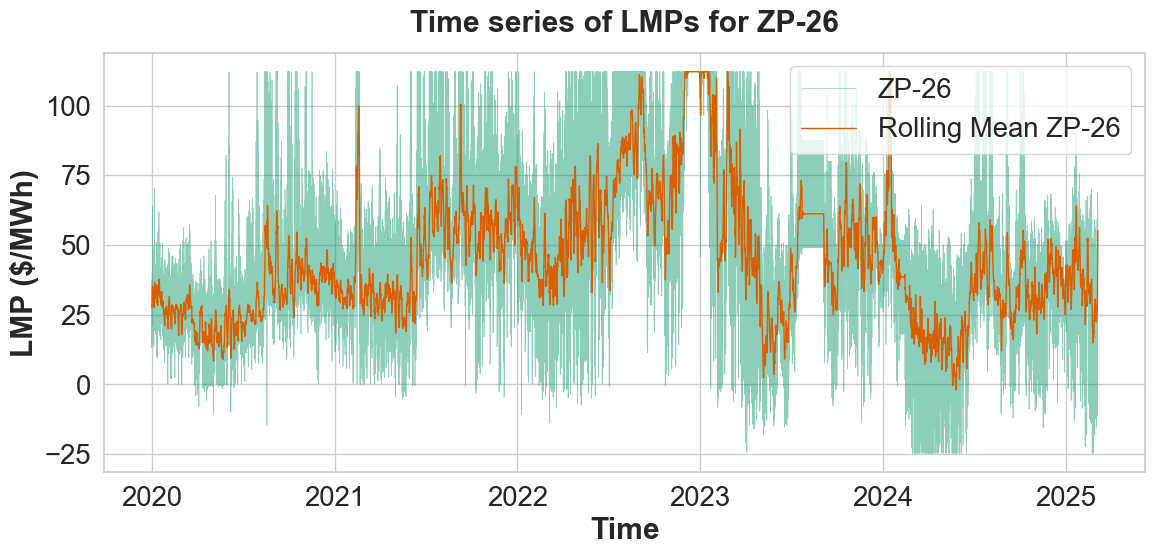

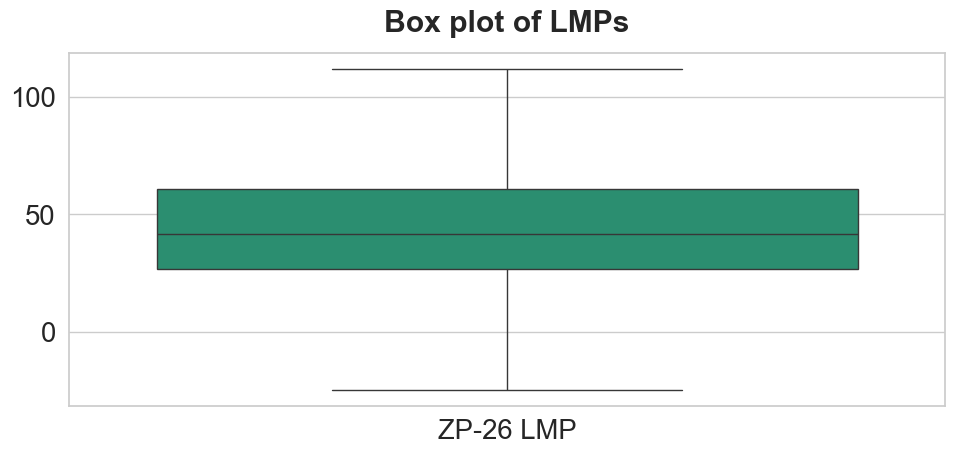

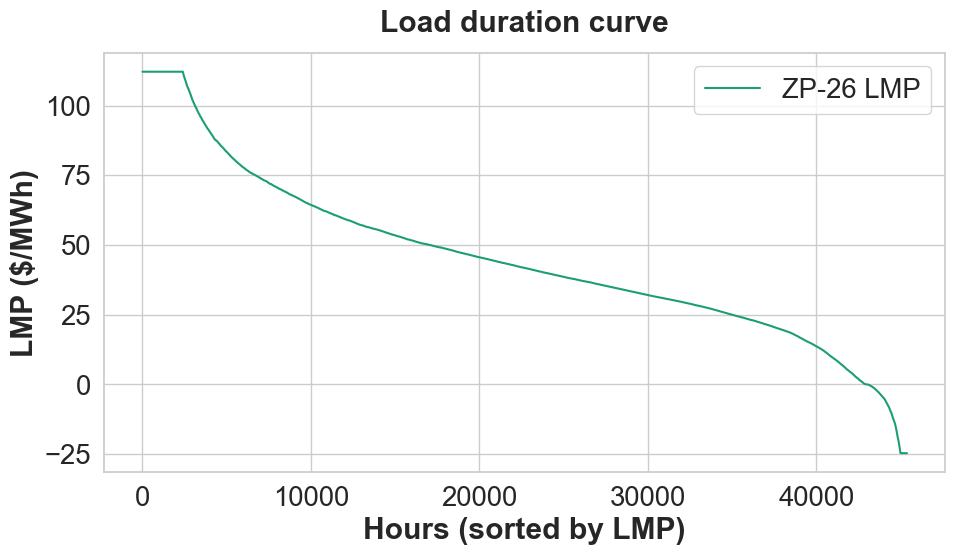

In [14]:
# outlier removal through IQR

df_tmp = imputed_df.copy()
df_tmp = remove_outliers_iqr(df_tmp, area_lmp)

plot_ts(df_tmp, area_lmp, areas, time_col="Local_Ending", name='IQR')

plot_boxplots(df_tmp, area_lmp, name='IQR')
plot_load_durations(df_tmp, area_lmp, name='IQR')

local_df = set_index(df_tmp, "Local_Ending")
print("\n Local Time-based data preview:")
print(local_df.head())

statistics = compute_statistics(local_df, area_lmp)


 Local Time-based data preview:
                           ZP-26 LMP
Local_Ending                        
2020-01-01 01:00:00-08:00   32.43298
2020-01-01 02:00:00-08:00   30.22250
2020-01-01 03:00:00-08:00   31.38129
2020-01-01 04:00:00-08:00   30.38648
2020-01-01 05:00:00-08:00   29.91375

Basic statistics:
             count       mean       std   min        25%       50%       75%  \
ZP-26 LMP  45384.0  48.266331  40.05865 -22.0  26.616045  41.74627  60.82069   

                 max  skewness  kurtosis  
ZP-26 LMP  257.12604  2.267084   8.48631  


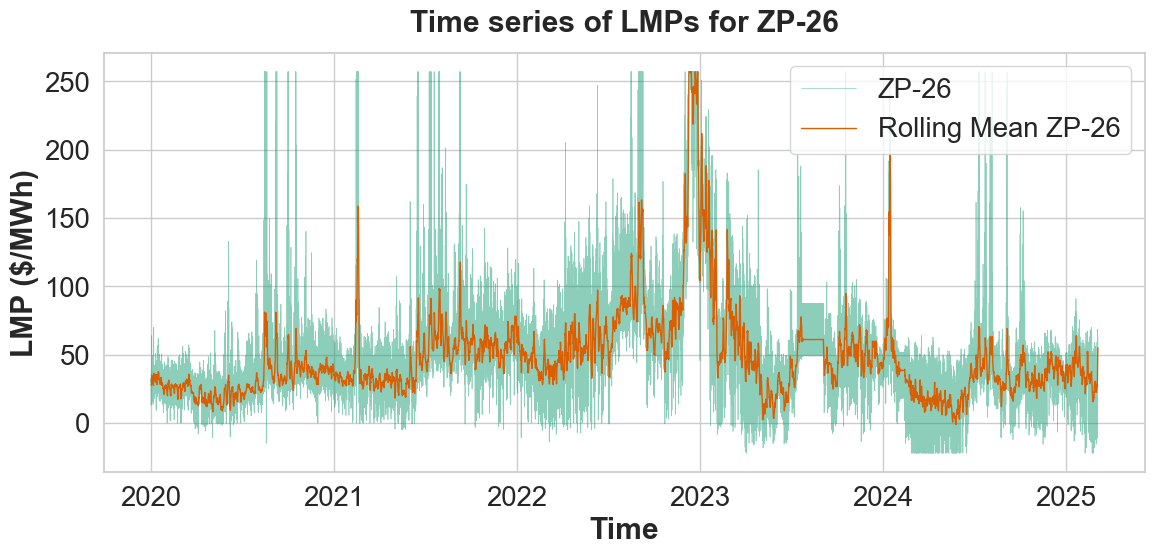

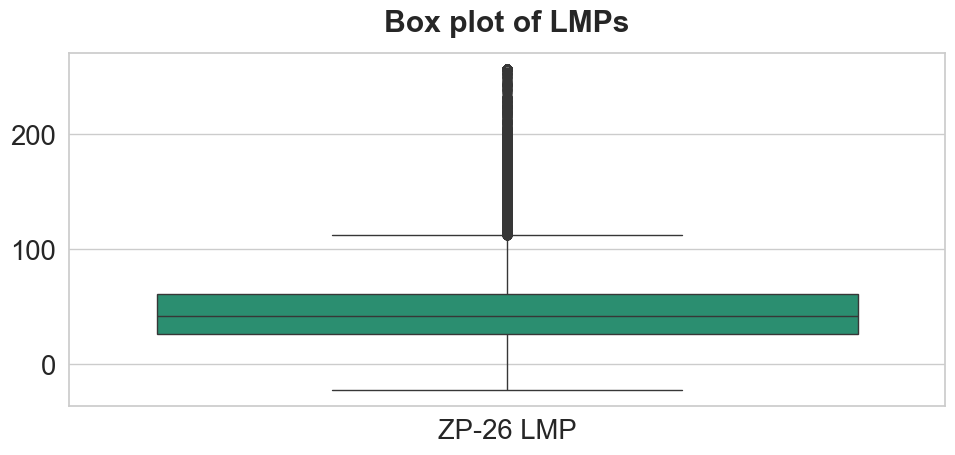

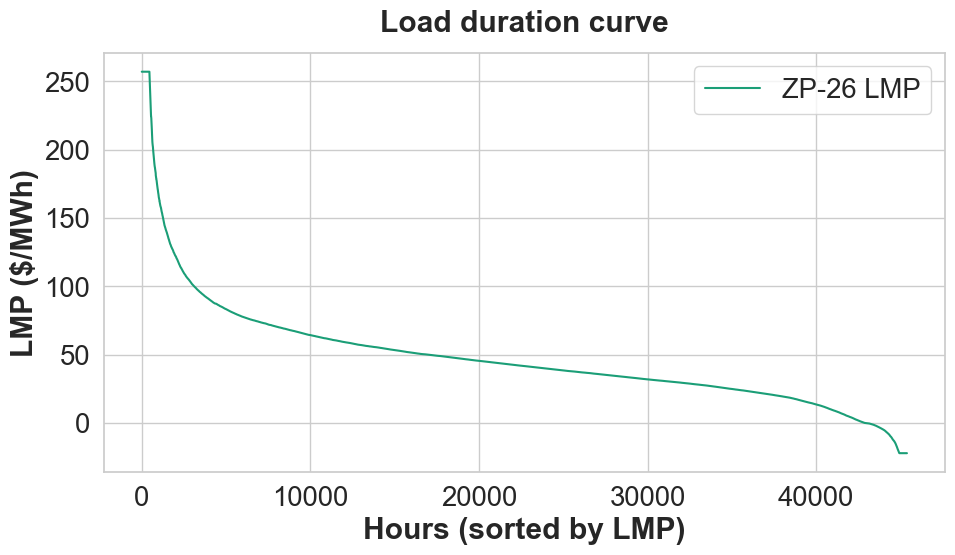

In [15]:
# outlier removal through winsorization

df_tmp = imputed_df.copy()
df_tmp = winsorize_outliers(df_tmp, area_lmp)

plot_ts(df_tmp, area_lmp, areas, time_col="Local_Ending", name='Winsorization')

plot_boxplots(df_tmp, area_lmp, name='Winsorization')
plot_load_durations(df_tmp, area_lmp, name='Winsorization')

local_df = set_index(df_tmp, "Local_Ending")
print("\n Local Time-based data preview:")
print(local_df.head())

statistics = compute_statistics(local_df, area_lmp)

### RF and XGB with volatility

Simulating ZP-26 for 2025-02-24 23:00:00
Simulating ZP-26 for 2025-02-25 00:00:00
Simulating ZP-26 for 2025-02-25 01:00:00
Simulating ZP-26 for 2025-02-25 02:00:00
Simulating ZP-26 for 2025-02-25 03:00:00
Simulating ZP-26 for 2025-02-25 04:00:00
Simulating ZP-26 for 2025-02-25 05:00:00
Simulating ZP-26 for 2025-02-25 06:00:00
Simulating ZP-26 for 2025-02-25 07:00:00
Simulating ZP-26 for 2025-02-25 08:00:00
Simulating ZP-26 for 2025-02-25 09:00:00
Simulating ZP-26 for 2025-02-25 10:00:00
Simulating ZP-26 for 2025-02-25 11:00:00
Simulating ZP-26 for 2025-02-25 12:00:00
Simulating ZP-26 for 2025-02-25 13:00:00
Simulating ZP-26 for 2025-02-25 14:00:00
Simulating ZP-26 for 2025-02-25 15:00:00
Simulating ZP-26 for 2025-02-25 16:00:00
Simulating ZP-26 for 2025-02-25 17:00:00
Simulating ZP-26 for 2025-02-25 18:00:00
Simulating ZP-26 for 2025-02-25 19:00:00
Simulating ZP-26 for 2025-02-25 20:00:00
Simulating ZP-26 for 2025-02-25 21:00:00
Simulating ZP-26 for 2025-02-25 22:00:00
Simulating ZP-26

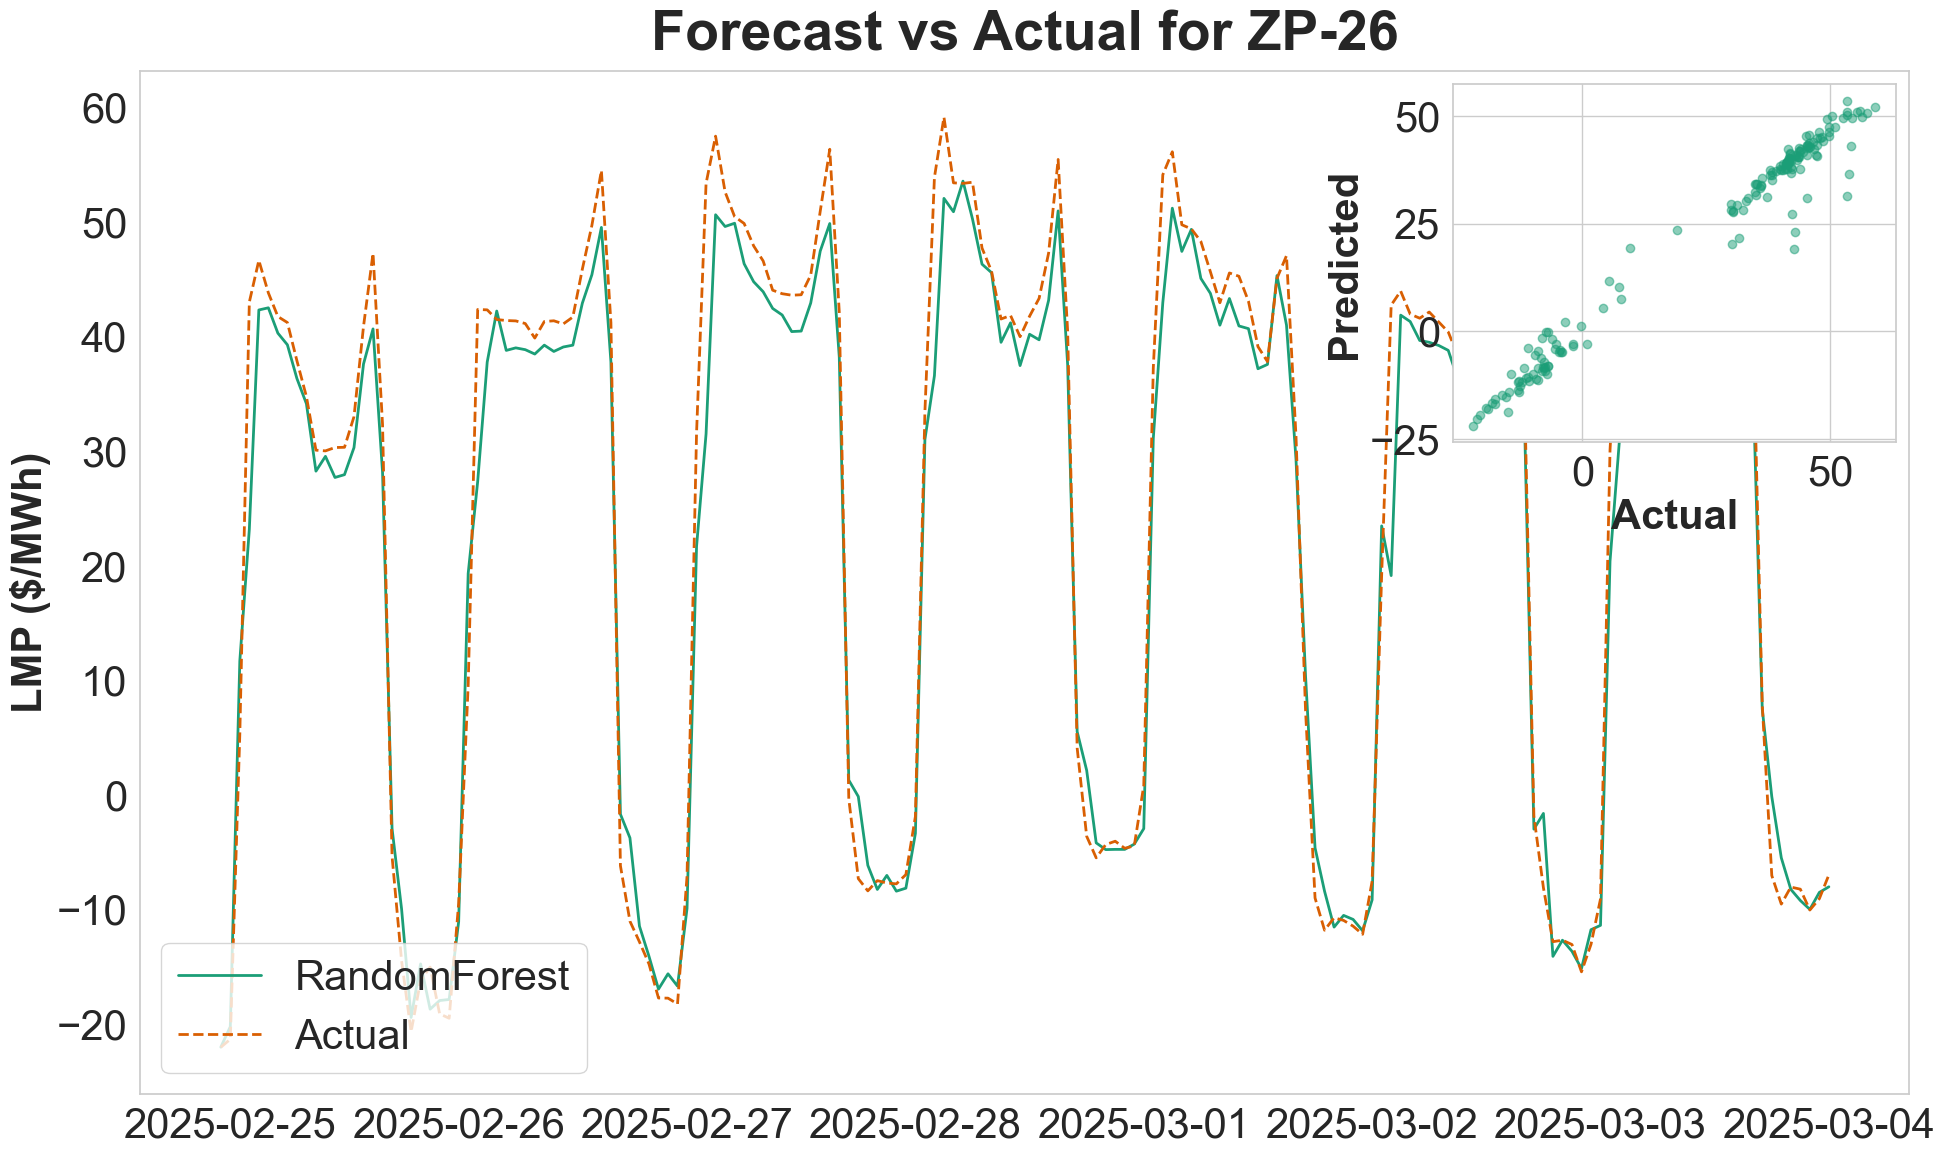

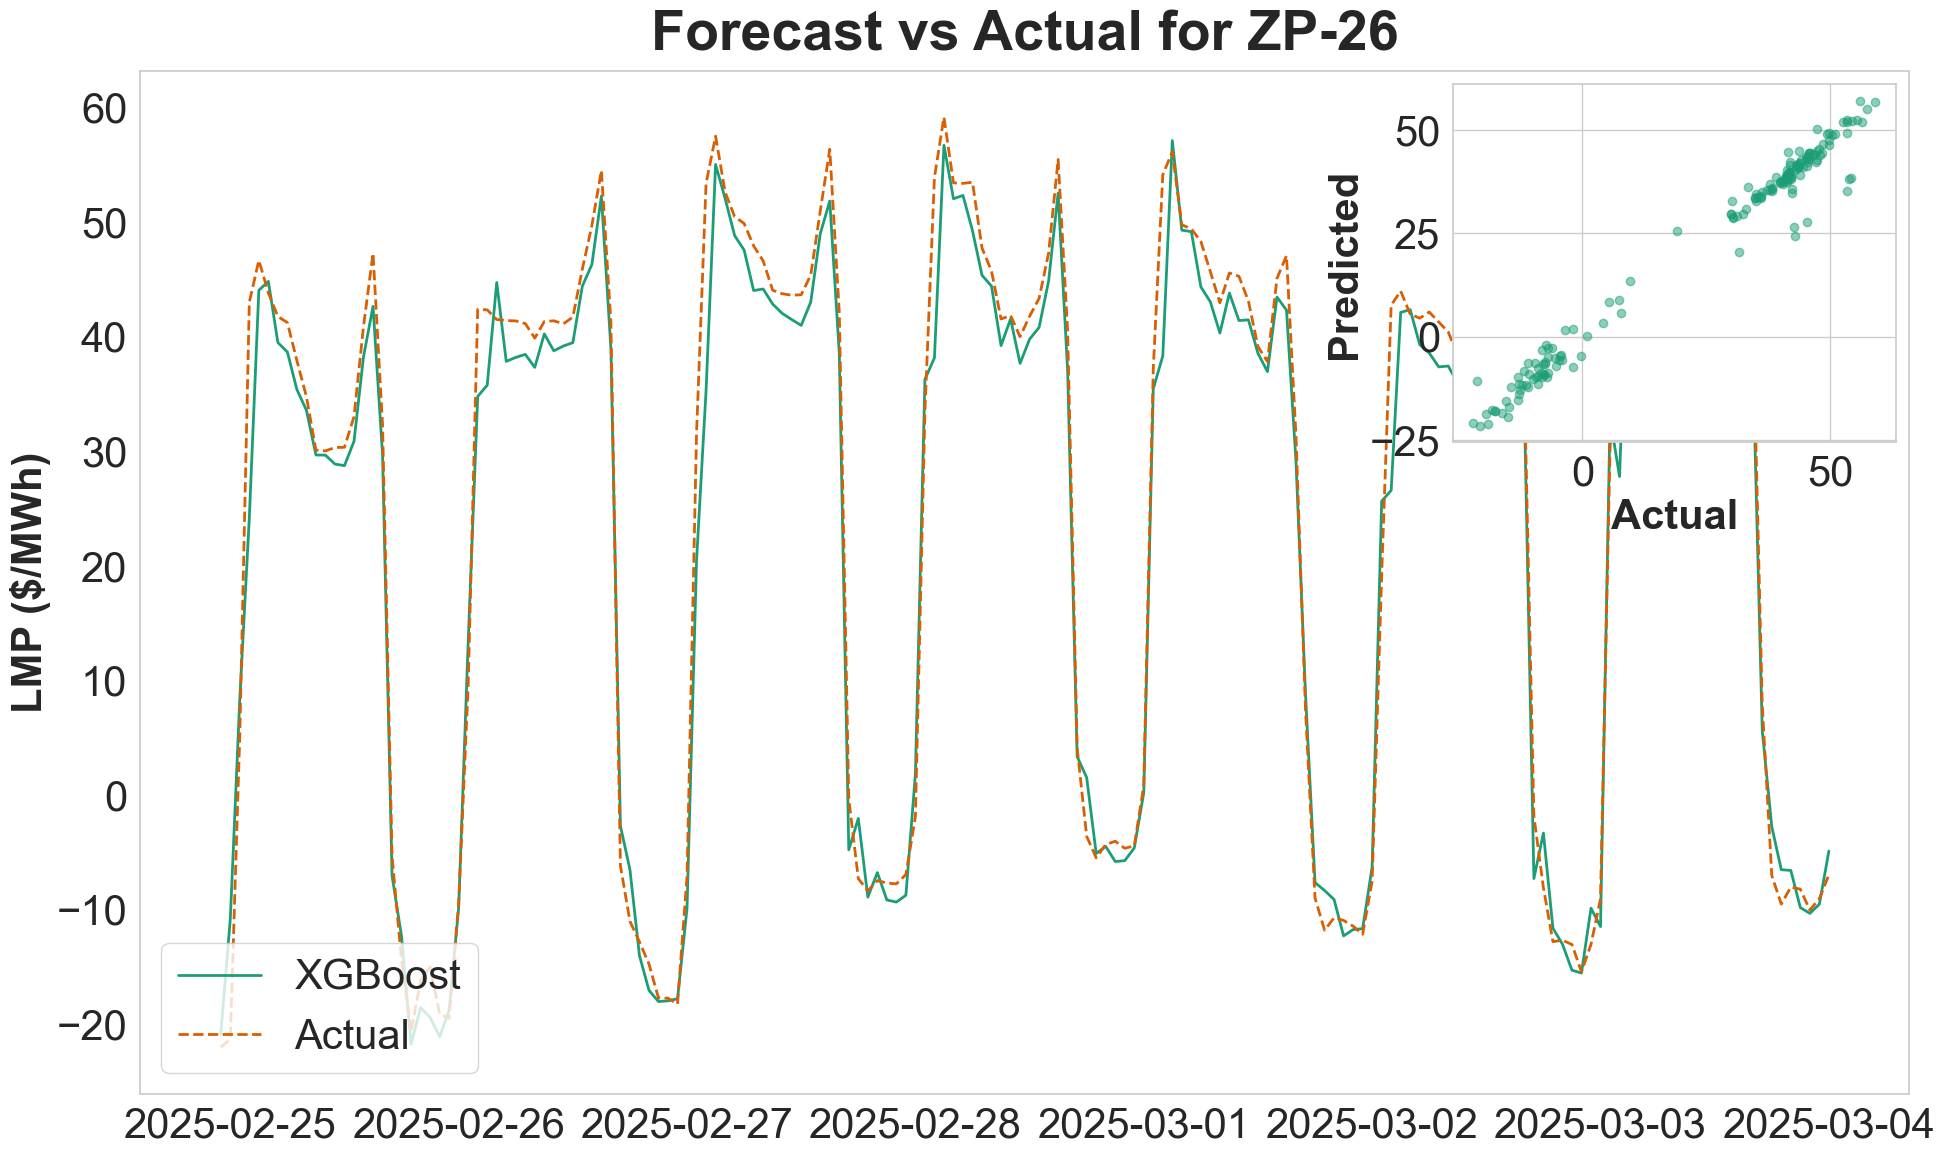

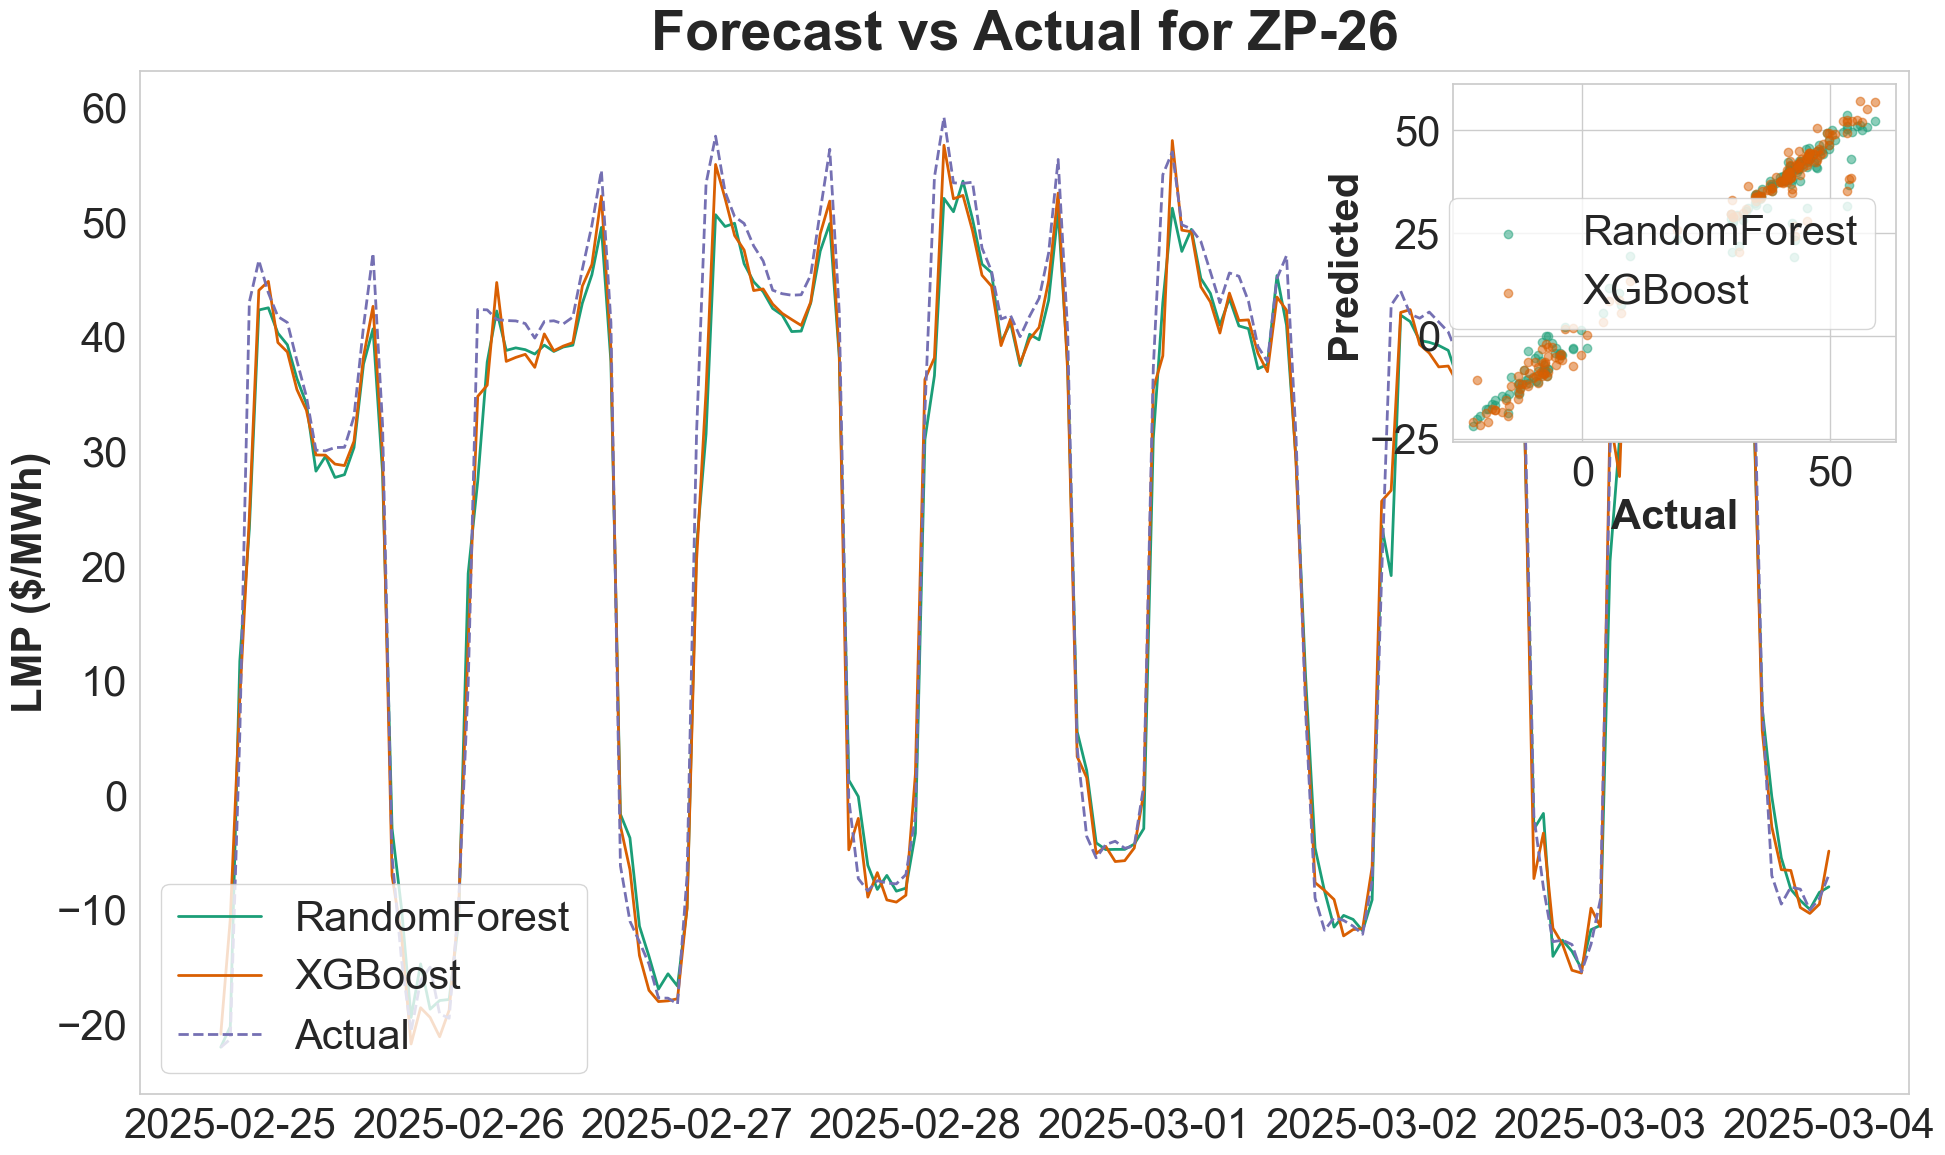

In [17]:
model1_name = 'Vol_RF'
model2_name = 'Vol_XGB'
name = 'Final'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_ext_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

for j in np.arange(len(areas)):
    
    df_train = df_train_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    df_test = df_test_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    
    lst_arima_train, lst_vol_train = get_res_vol(df_train, area_lmp[j], best_arima_order, best_garch_order)
    lst_arima_test, lst_vol_test = get_res_vol(df_test, area_lmp[j], best_arima_order, best_garch_order)
    
    df_train['ARIMA_res'] = lst_arima_train
    df_train['GARCH_vol'] = lst_vol_train
    
    df_test['ARIMA_res'] = lst_arima_test
    df_test['GARCH_vol'] = lst_vol_test
    
    df_train[f'{areas[j]} Lag'] = df_train[area_lmp[j]].shift(1)
    df_train[f'{areas[j]} Roll'] = df_train[area_lmp[j]].rolling(24).mean()
    df_train[f'{areas[j]} Std'] = df_train[area_lmp[j]].rolling(24).std()
    
    df_test[f'{areas[j]} Lag'] = df_test[area_lmp[j]].shift(1)
    df_test[f'{areas[j]} Roll'] = df_test[area_lmp[j]].rolling(24).mean()
    df_test[f'{areas[j]} Std'] = df_test[area_lmp[j]].rolling(24).std()
    
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    
    X_train = df_train[['ARIMA_res', 'GARCH_vol', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_train = df_train[area_lmp[j]].values
    
    X_test = df_test[['ARIMA_res', 'GARCH_vol', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_test = df_test[area_lmp[j]].values

    rf_model = RandomForestRegressor(random_state=42)
    gb_model = XGBRegressor(random_state=42)
    
    # Hyperparameter Tuning for RandomForest
    param_grid_rf = {
        'n_estimators': [100, 200], 
        'max_depth': [5,10]
    }

   # Hyperparameter Tuning for XGBoost
    param_grid_gb = {
        'n_estimators': [100, 200], 
        'learning_rate': [0.01, 0.1],
        'max_depth': [5,10]
    }
    
    prediction_rf, prediction_gb, actual_values = [], [], []

    for i in range(len(df_test)):
        
        print(f'Simulating {areas[j]} for {df_test.index[i]}')

        rf_grid = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
        rf_grid.fit(X_train, y_train)
        best_rf = rf_grid.best_estimator_
        
        gb_grid = GridSearchCV(gb_model, param_grid_gb, cv=3, scoring='neg_mean_absolute_error')
        gb_grid.fit(X_train, y_train)
        best_gb = gb_grid.best_estimator_

        rf_pred = best_rf.predict([X_test[i]])[0]
        gb_pred = best_gb.predict([X_test[i]])[0]

        prediction_rf.append(rf_pred)
        prediction_gb.append(gb_pred)
        actual_values.append(y_test[i])
        
        new_data = np.append(X_test[i], y_test[i]).reshape(1,-1)
        X_train = np.vstack([X_train, new_data[:, :-1]])
        y_train = np.append(y_train, new_data[:, -1])
    
    comparative_plot1(df_test, areas[j], actual_values, prediction_rf, var1='Actual', var2='RandomForest', name=name)
    comparative_plot1(df_test, areas[j], actual_values, prediction_gb, var1='Actual', var2='XGBoost', name=name)
    comparative_plot2(df_test, areas[j], actual_values, prediction_rf, prediction_gb, var1='Actual', var2='RandomForest', var3='XGBoost', name=name)
    
    mae_rf = mean_absolute_error(actual_values, prediction_rf)
    mse_rf = mean_squared_error(actual_values, prediction_rf)
    print(f'{areas[j]} RandomForest MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}')
    
    mae_gb = mean_absolute_error(actual_values, prediction_gb)
    mse_gb = mean_squared_error(actual_values, prediction_gb)
    print(f'{areas[j]} GradientBoost MAE: {mae_gb:.4f}, MSE: {mse_gb:.4f}')

    new_df_rf = pd.DataFrame(index=df_test.index)
    new_df_rf['Actual'] = actual_values
    new_df_rf['Prediction'] = prediction_rf
    
    new_df_rf.to_csv(file_path + model1_name + '_' + areas[j] + '.csv')
    
    new_df_gb = pd.DataFrame(index=df_test.index)
    new_df_gb['Actual'] = actual_values
    new_df_gb['Prediction'] = prediction_gb
    
    new_df_gb.to_csv(file_path + model2_name + '_' + areas[j] + '.csv')

### RF and XGB with enhanced features but no volatility

Simulating ZP-26 for 2025-02-24 23:00:00
Simulating ZP-26 for 2025-02-25 00:00:00
Simulating ZP-26 for 2025-02-25 01:00:00
Simulating ZP-26 for 2025-02-25 02:00:00
Simulating ZP-26 for 2025-02-25 03:00:00
Simulating ZP-26 for 2025-02-25 04:00:00
Simulating ZP-26 for 2025-02-25 05:00:00
Simulating ZP-26 for 2025-02-25 06:00:00
Simulating ZP-26 for 2025-02-25 07:00:00
Simulating ZP-26 for 2025-02-25 08:00:00
Simulating ZP-26 for 2025-02-25 09:00:00
Simulating ZP-26 for 2025-02-25 10:00:00
Simulating ZP-26 for 2025-02-25 11:00:00
Simulating ZP-26 for 2025-02-25 12:00:00
Simulating ZP-26 for 2025-02-25 13:00:00
Simulating ZP-26 for 2025-02-25 14:00:00
Simulating ZP-26 for 2025-02-25 15:00:00
Simulating ZP-26 for 2025-02-25 16:00:00
Simulating ZP-26 for 2025-02-25 17:00:00
Simulating ZP-26 for 2025-02-25 18:00:00
Simulating ZP-26 for 2025-02-25 19:00:00
Simulating ZP-26 for 2025-02-25 20:00:00
Simulating ZP-26 for 2025-02-25 21:00:00
Simulating ZP-26 for 2025-02-25 22:00:00
Simulating ZP-26

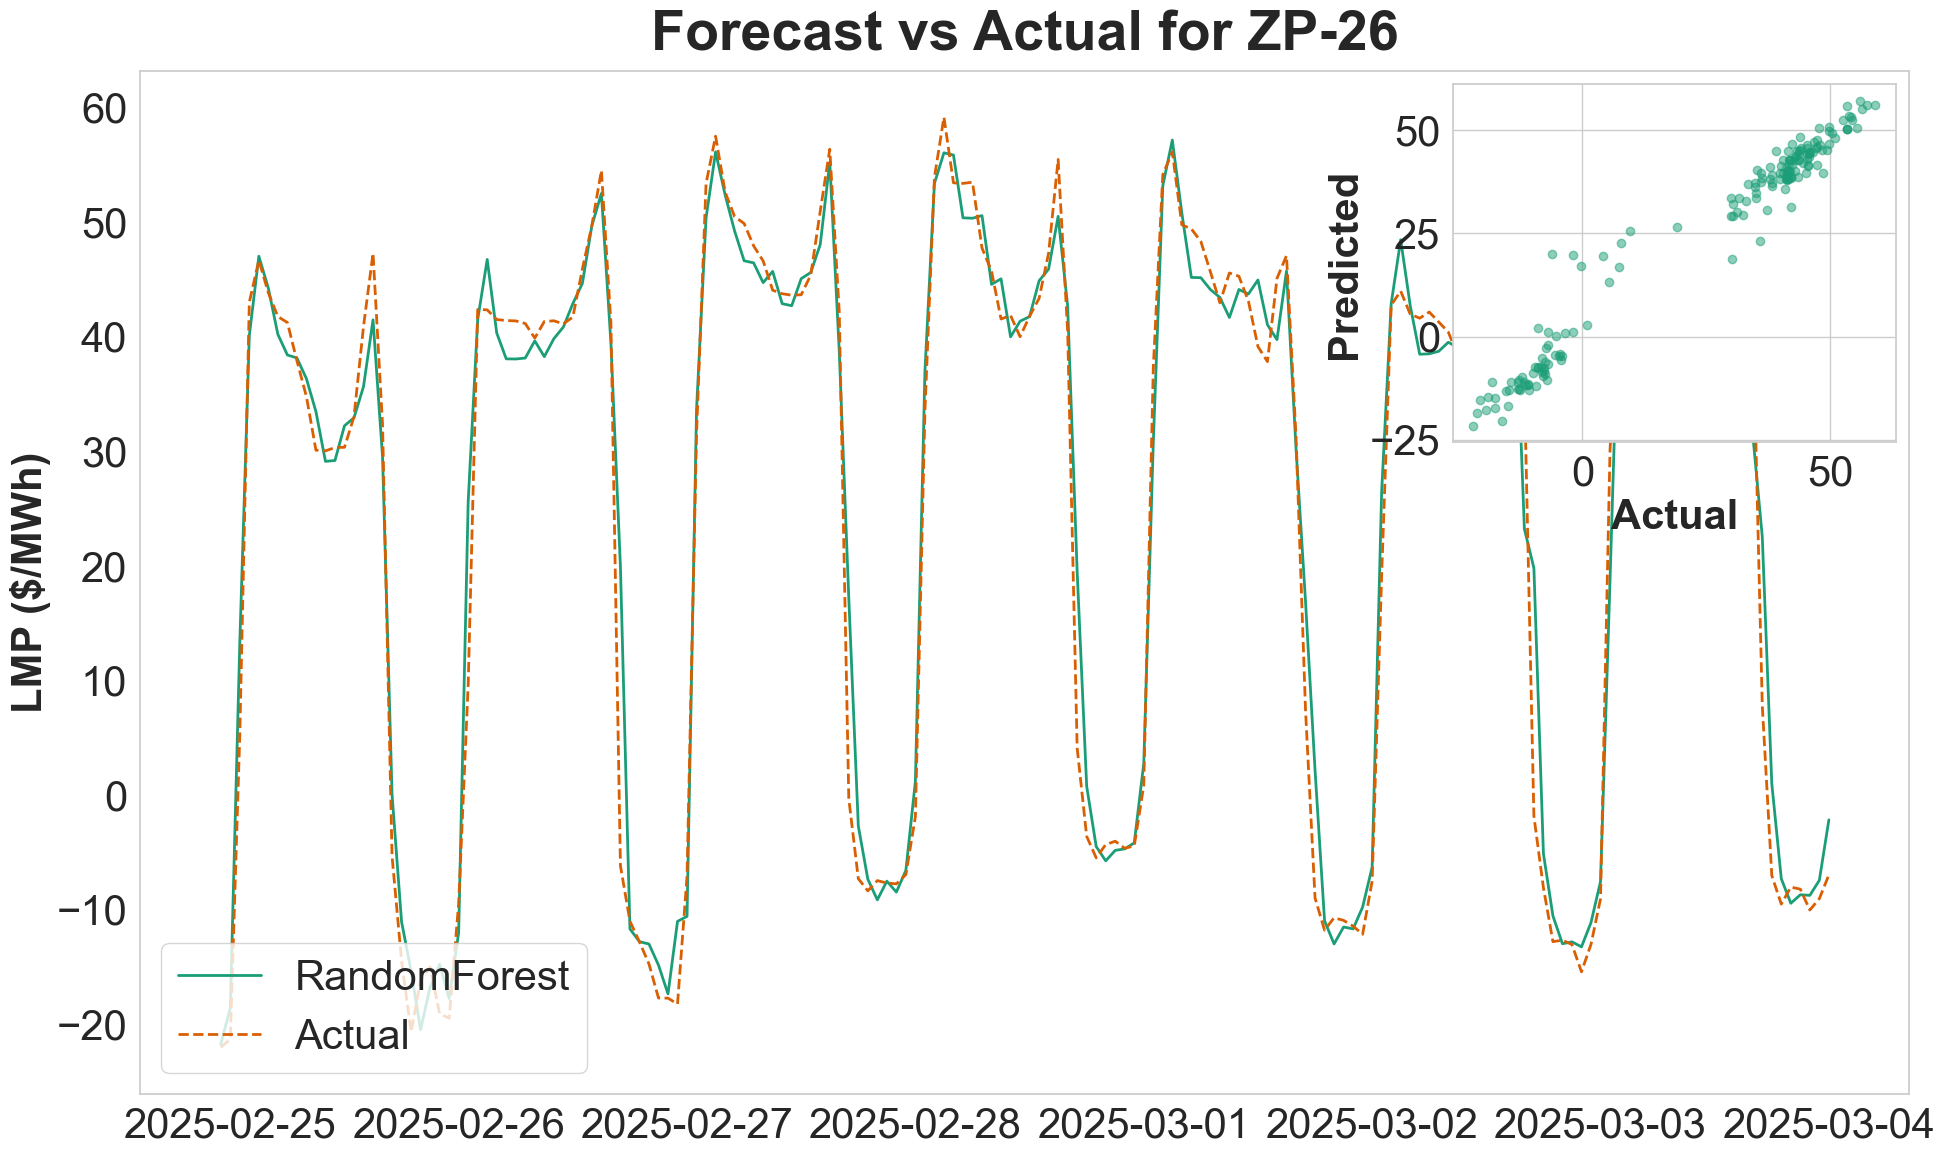

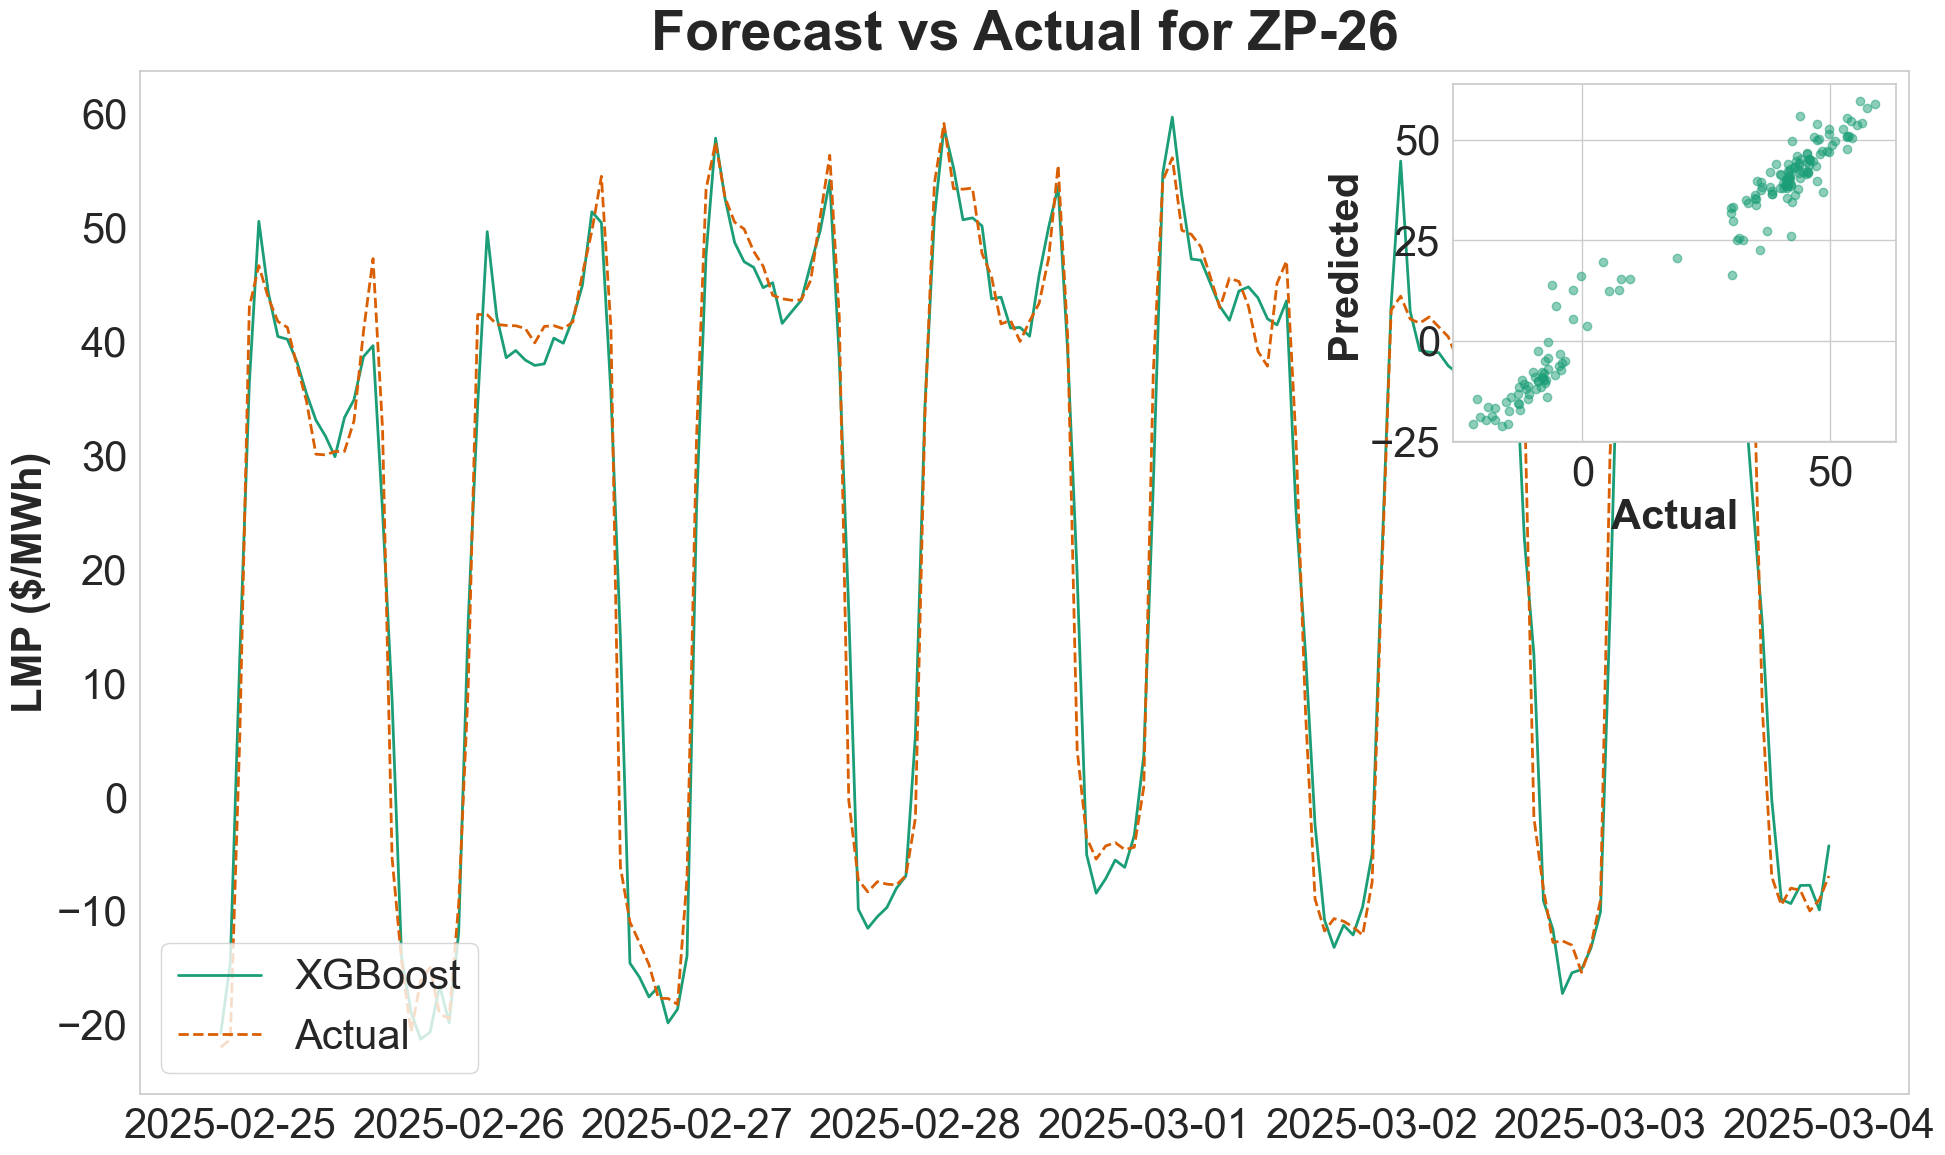

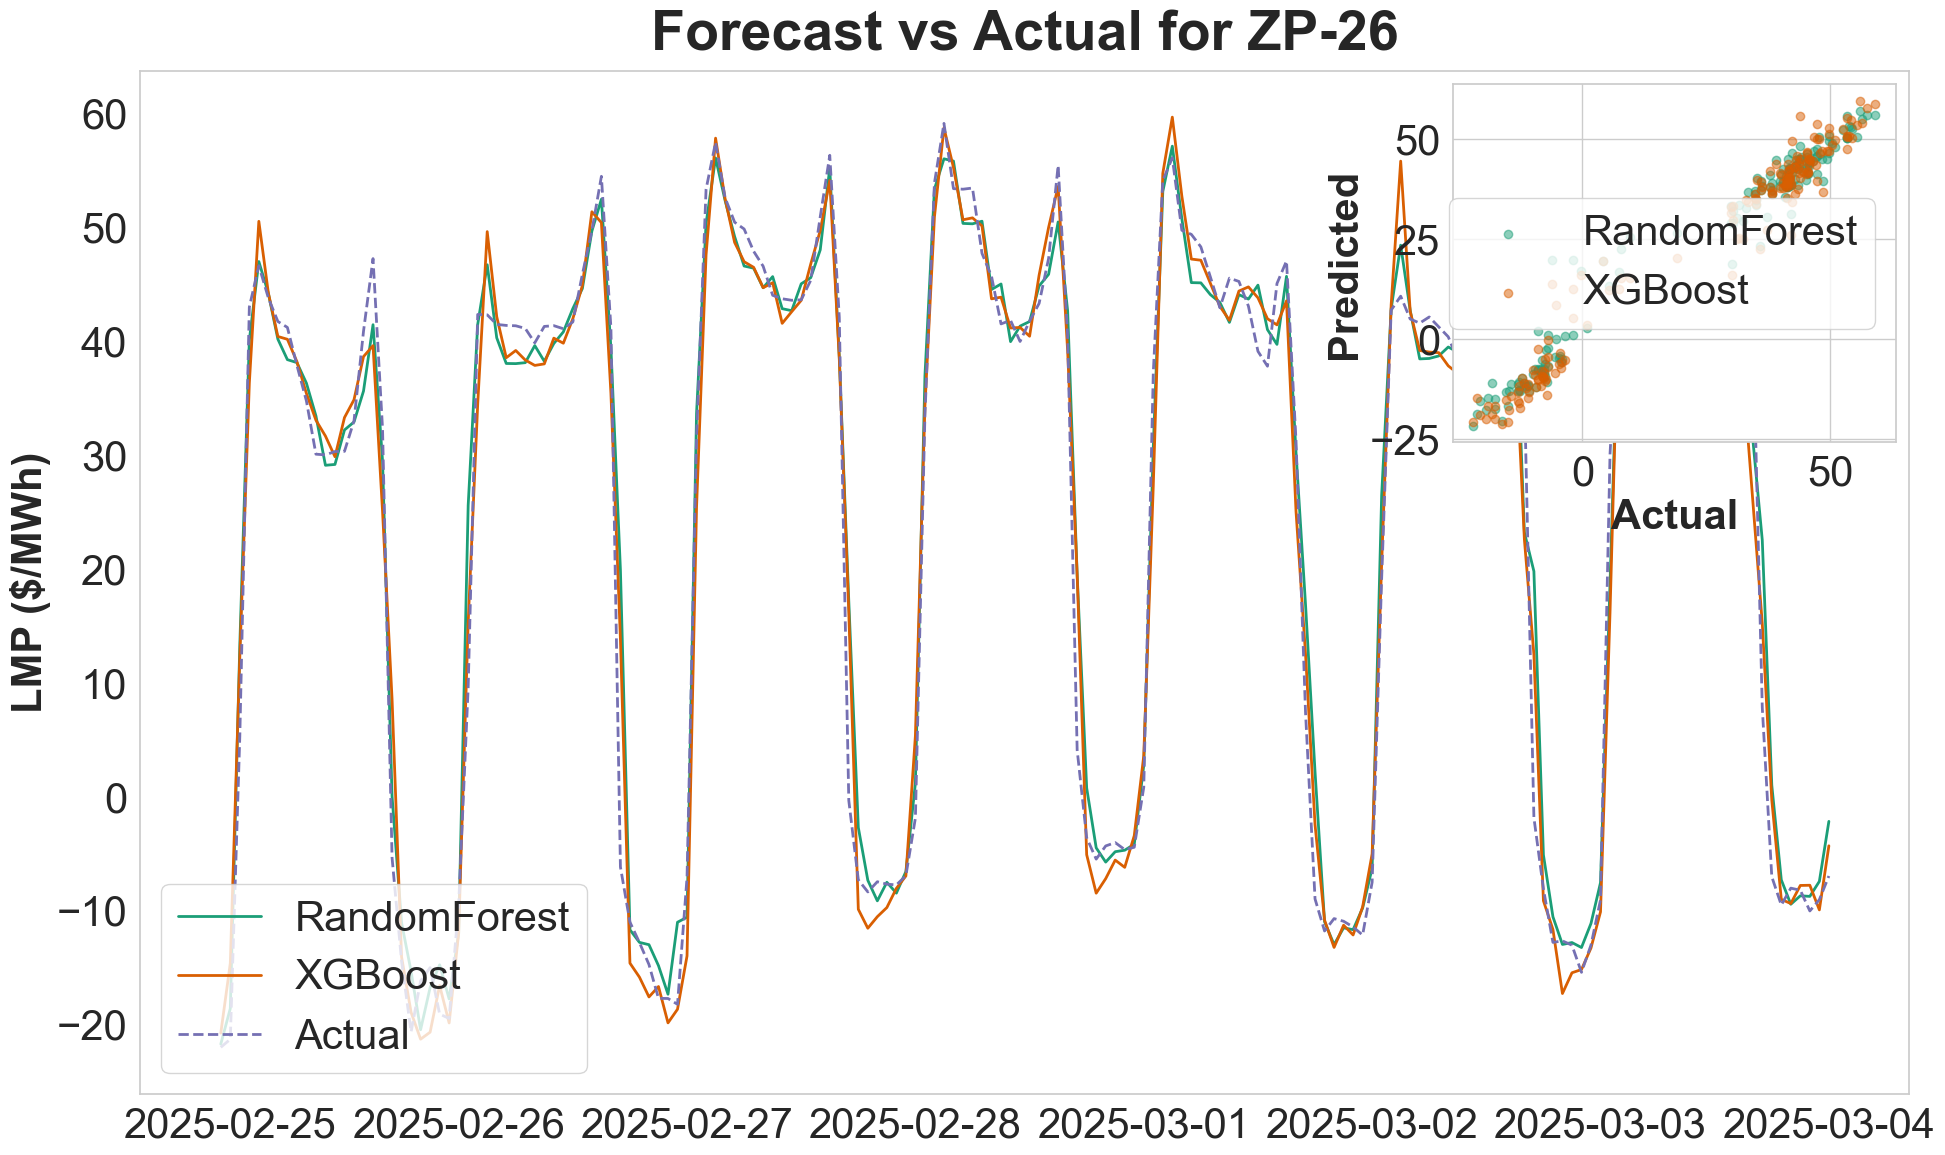

In [19]:
model1_name = 'Enhanced_features_RF'
model2_name = 'Enhanced_features_XGB'
name = 'Advanced'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_ext_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

for j in np.arange(len(areas)):
    
    df_train = df_train_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    df_test = df_test_complete[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', area_lmp[j]]]
    
    df_train[f'{areas[j]} Lag'] = df_train[area_lmp[j]].shift(1)
    df_train[f'{areas[j]} Roll'] = df_train[area_lmp[j]].rolling(24).mean()
    df_train[f'{areas[j]} Std'] = df_train[area_lmp[j]].rolling(24).std()
    
    df_test[f'{areas[j]} Lag'] = df_test[area_lmp[j]].shift(1)
    df_test[f'{areas[j]} Roll'] = df_test[area_lmp[j]].rolling(24).mean()
    df_test[f'{areas[j]} Std'] = df_test[area_lmp[j]].rolling(24).std()
    
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    
    X_train = df_train[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_train = df_train[area_lmp[j]].values
    
    X_test = df_test[['hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', f'{areas[j]} Lag', f'{areas[j]} Roll', f'{areas[j]} Std']].values
    y_test = df_test[area_lmp[j]].values
    
    rf_model = RandomForestRegressor(random_state=42)
    gb_model = XGBRegressor(random_state=42)
    
    # Hyperparameter Tuning for RandomForest
    param_grid_rf = {
        'n_estimators': [100, 200], 
        'max_depth': [5,10]
    }
    
    # Hyperparameter Tuning for XGBoost
    param_grid_gb = {
        'n_estimators': [100, 200], 
        'learning_rate': [0.01, 0.1],
        'max_depth': [5,10]
    }
    
    prediction_rf, prediction_gb, actual_values = [], [], []
    
    for i in range(len(df_test)):
        
        print(f'Simulating {areas[j]} for {df_test.index[i]}')

        rf_grid = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='neg_mean_absolute_error')
        rf_grid.fit(X_train, y_train)
        best_rf = rf_grid.best_estimator_

        gb_grid = GridSearchCV(gb_model, param_grid_gb, cv=3, scoring='neg_mean_absolute_error')
        gb_grid.fit(X_train, y_train)
        best_gb = gb_grid.best_estimator_
    
        rf_pred = best_rf.predict([X_test[i]])[0]
        gb_pred = best_gb.predict([X_test[i]])[0]
        
        prediction_rf.append(rf_pred)
        prediction_gb.append(gb_pred)
        actual_values.append(y_test[i])
        
        new_data = np.append(X_test[i], y_test[i]).reshape(1,-1)
        X_train = np.vstack([X_train, new_data[:, :-1]])
        y_train = np.append(y_train, new_data[:, -1])

    comparative_plot1(df_test, areas[j], actual_values, prediction_rf, var1='Actual', var2='RandomForest', name=name)
    comparative_plot1(df_test, areas[j], actual_values, prediction_gb, var1='Actual', var2='XGBoost', name=name)
    comparative_plot2(df_test, areas[j], actual_values, prediction_rf, prediction_gb, var1='Actual', var2='RandomForest', var3='XGBoost', name=name)
    
    mae_rf = mean_absolute_error(actual_values, prediction_rf)
    mse_rf = mean_squared_error(actual_values, prediction_rf)
    
    mae_gb = mean_absolute_error(actual_values, prediction_gb)
    mse_gb = mean_squared_error(actual_values, prediction_gb)
    
    print(f'{areas[j]} - RandomForest MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}')
    print(f'{areas[j]} - GradientBoosting MAE: {mae_gb:.4f}, MSE: {mse_gb:.4f}')
    
    new_df_rf = pd.DataFrame(index=df_test.index)
    new_df_rf['Actual'] = actual_values
    new_df_rf['Prediction'] = prediction_rf
    
    new_df_rf.to_csv(file_path + model1_name + '_' + areas[j] + '.csv')
    
    new_df_gb = pd.DataFrame(index=df_test.index)
    new_df_gb['Actual'] = actual_values
    new_df_gb['Prediction'] = prediction_gb
    
    new_df_gb.to_csv(file_path + model2_name + '_' + areas[j] + '.csv')

### Simple RF and XGB models

Simulating ZP-26 for 2025-02-24 23:00:00
Simulating ZP-26 for 2025-02-25 00:00:00
Simulating ZP-26 for 2025-02-25 01:00:00
Simulating ZP-26 for 2025-02-25 02:00:00
Simulating ZP-26 for 2025-02-25 03:00:00
Simulating ZP-26 for 2025-02-25 04:00:00
Simulating ZP-26 for 2025-02-25 05:00:00
Simulating ZP-26 for 2025-02-25 06:00:00
Simulating ZP-26 for 2025-02-25 07:00:00
Simulating ZP-26 for 2025-02-25 08:00:00
Simulating ZP-26 for 2025-02-25 09:00:00
Simulating ZP-26 for 2025-02-25 10:00:00
Simulating ZP-26 for 2025-02-25 11:00:00
Simulating ZP-26 for 2025-02-25 12:00:00
Simulating ZP-26 for 2025-02-25 13:00:00
Simulating ZP-26 for 2025-02-25 14:00:00
Simulating ZP-26 for 2025-02-25 15:00:00
Simulating ZP-26 for 2025-02-25 16:00:00
Simulating ZP-26 for 2025-02-25 17:00:00
Simulating ZP-26 for 2025-02-25 18:00:00
Simulating ZP-26 for 2025-02-25 19:00:00
Simulating ZP-26 for 2025-02-25 20:00:00
Simulating ZP-26 for 2025-02-25 21:00:00
Simulating ZP-26 for 2025-02-25 22:00:00
Simulating ZP-26

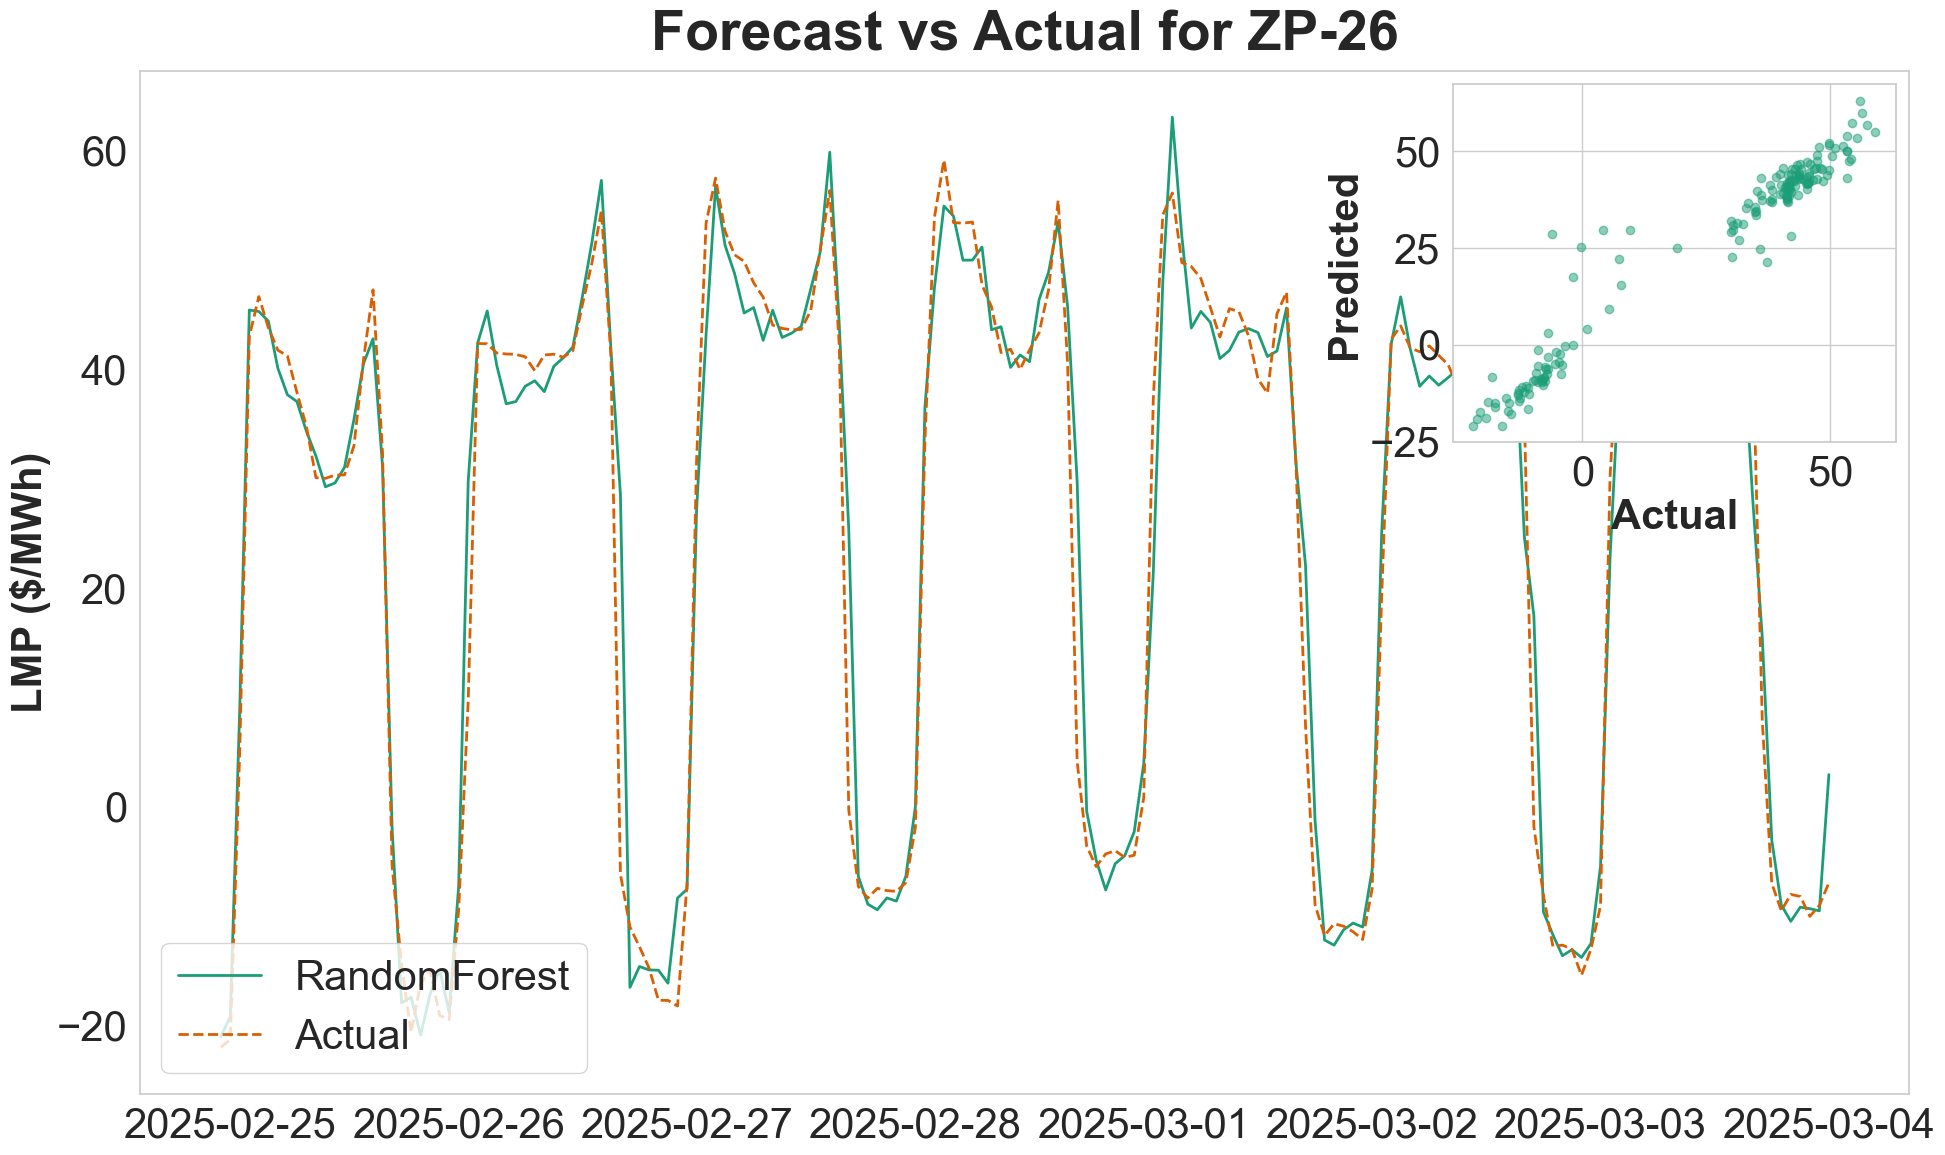

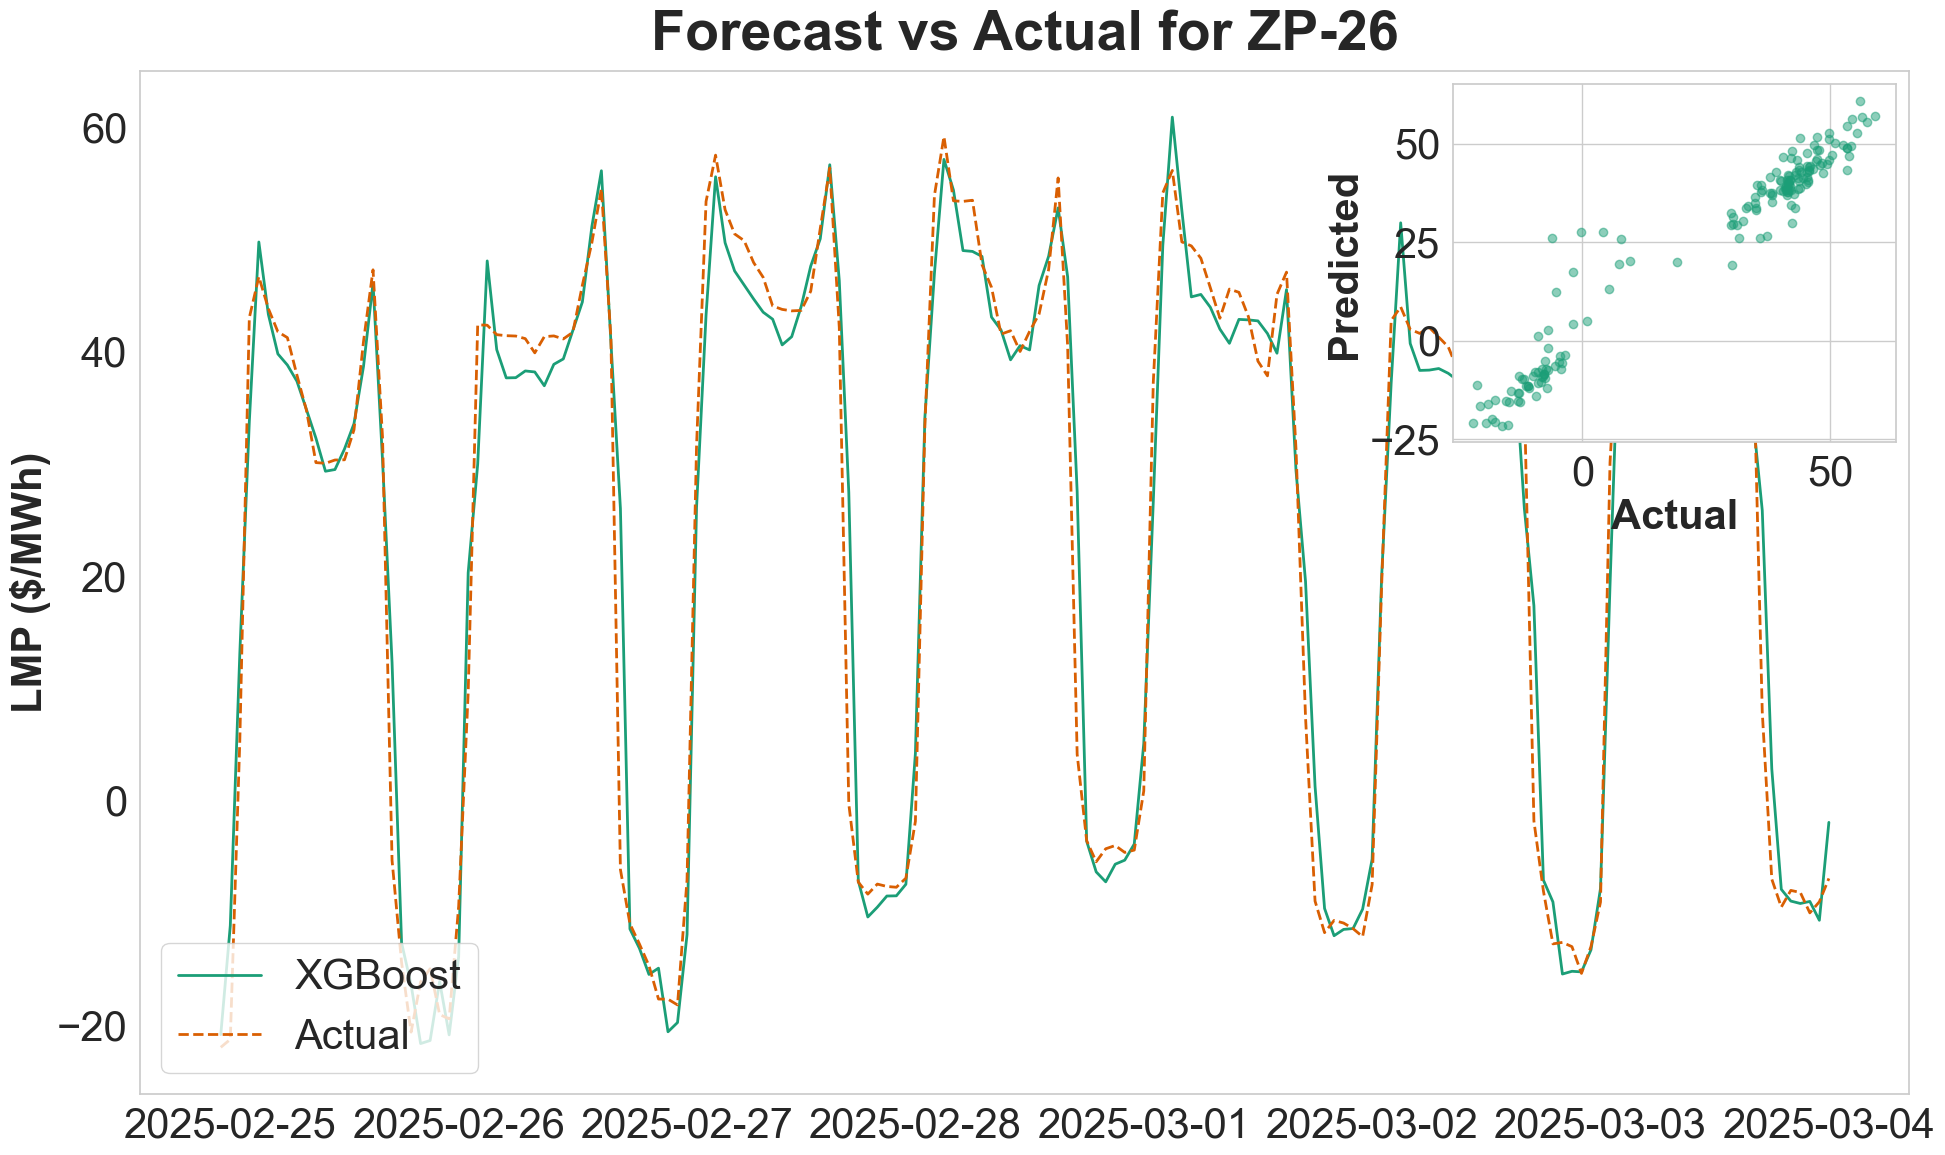

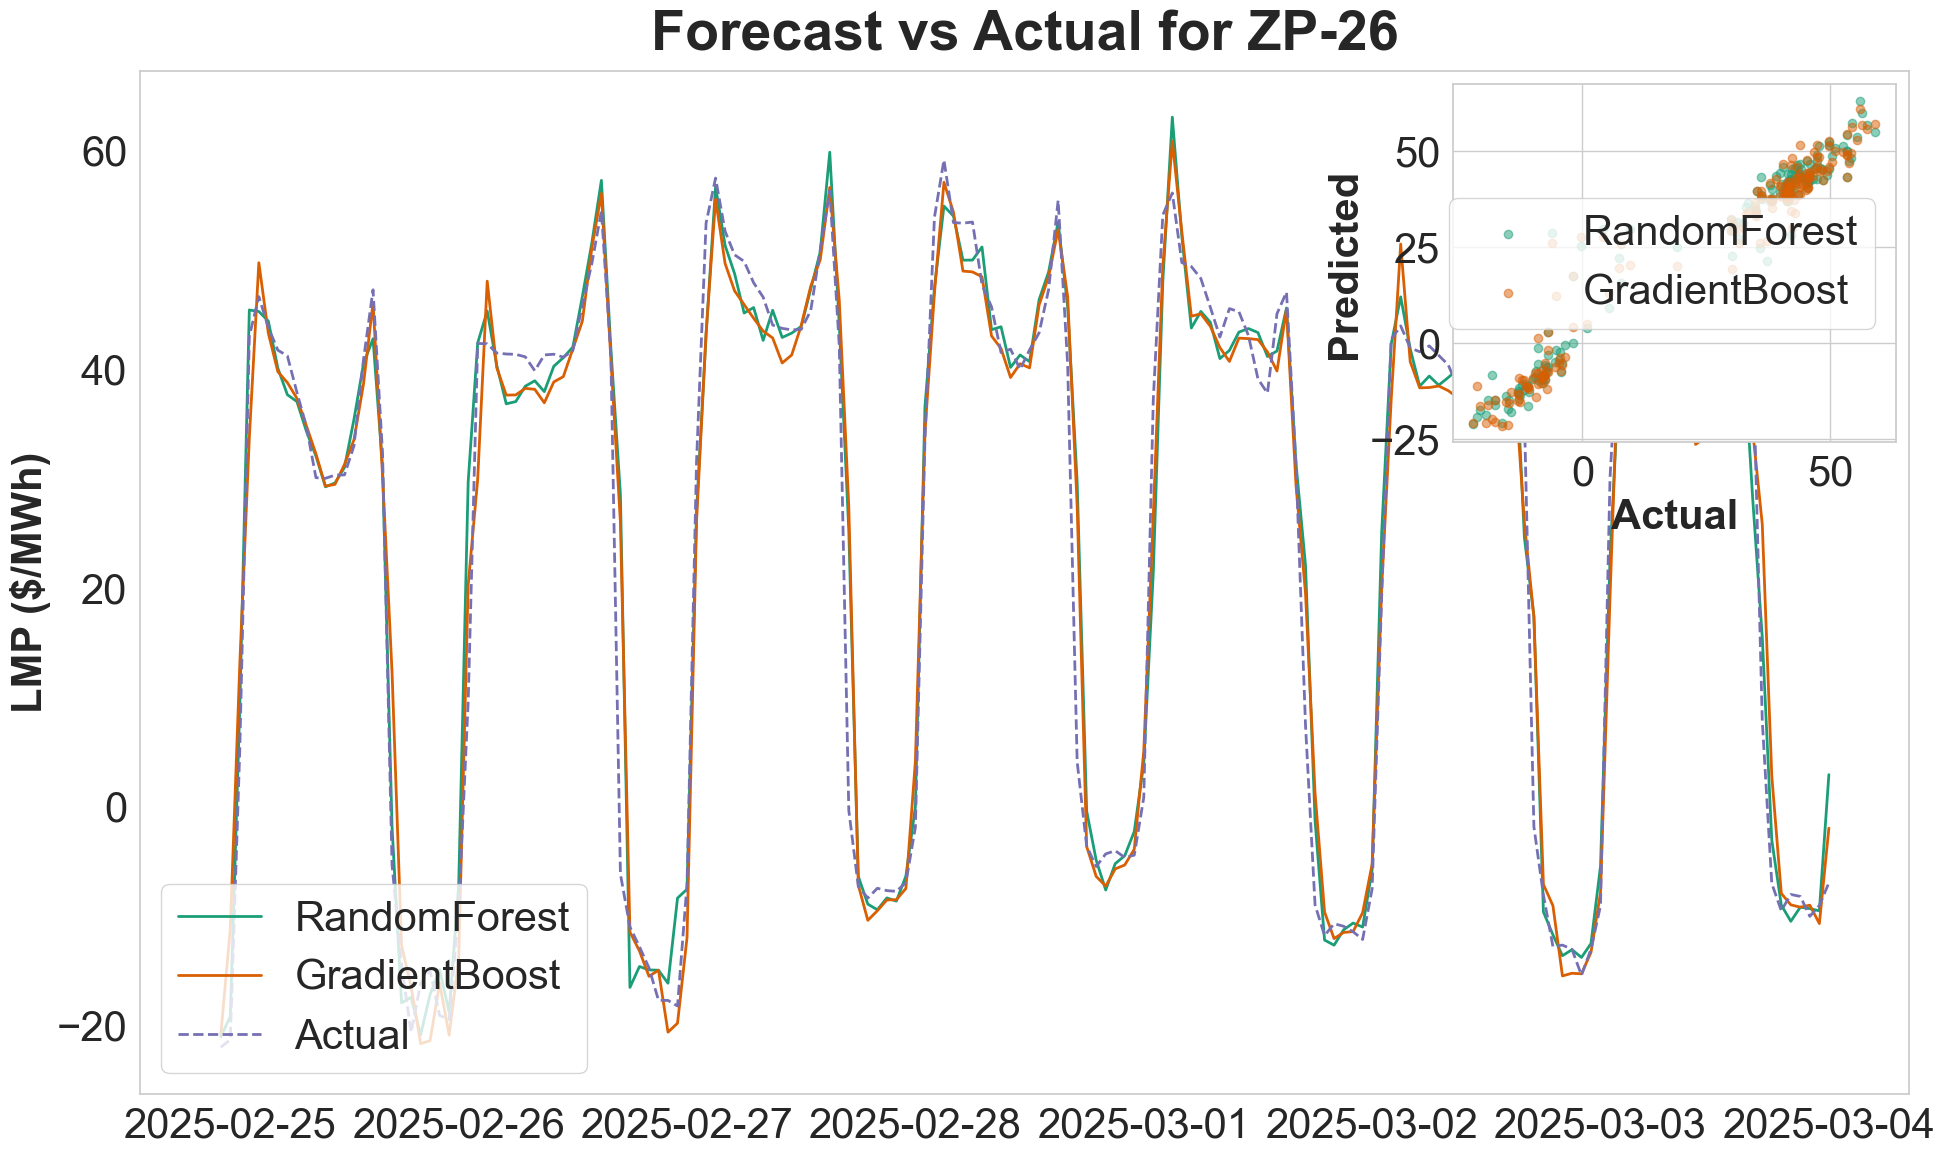

In [21]:
model1_name = 'Simple_RF'
model2_name = 'Simple_XGB'
name = 'Basic'

df = imputed_df.copy()
df = winsorize_outliers(df, area_lmp)

df = get_timecols(df)
df_train_complete, df_test_complete = get_train_test(df, split_date, test_end, time_delta)

for j in np.arange(len(areas)):
    
    df_train = df_train_complete[['hour', 'month', 'dayofweek', area_lmp[j]]]
    df_test = df_test_complete[['hour', 'month', 'dayofweek', area_lmp[j]]]
    
    df_train[f'{areas[j]} Lag'] = df_train[area_lmp[j]].shift(1)
    df_train[f'{areas[j]} Roll'] = df_train[area_lmp[j]].rolling(24).mean()
    
    df_test[f'{areas[j]} Lag'] = df_test[area_lmp[j]].shift(1)
    df_test[f'{areas[j]} Roll'] = df_test[area_lmp[j]].rolling(24).mean()
    
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    
    X_train = df_train[['hour', 'month', 'dayofweek', f'{areas[j]} Lag', f'{areas[j]} Roll']].values
    y_train = df_train[area_lmp[j]].values
    
    X_test = df_test[['hour', 'month', 'dayofweek', f'{areas[j]} Lag', f'{areas[j]} Roll']].values
    y_test = df_test[area_lmp[j]].values
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    gb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    prediction_rf, prediction_gb, actual_values = [], [], []
    
    for i in range(len(df_test)):
        
        print(f'Simulating {areas[j]} for {df_test.index[i]}')
        
        rf_model.fit(X_train, y_train)
        gb_model.fit(X_train, y_train)

        rf_pred = rf_model.predict([X_test[i]])[0]
        gb_pred = gb_model.predict([X_test[i]])[0]
        
        prediction_rf.append(rf_pred)
        prediction_gb.append(gb_pred)
        actual_values.append(y_test[i])
        
        new_data = np.append(X_test[i], y_test[i]).reshape(1,-1)
        X_train = np.vstack([X_train, new_data[:, :-1]])
        y_train = np.append(y_train, new_data[:, -1])

    comparative_plot1(df_test, areas[j], actual_values, prediction_rf, var1='Actual', var2='RandomForest', name=name)
    comparative_plot1(df_test, areas[j], actual_values, prediction_gb, var1='Actual', var2='XGBoost', name=name)
    comparative_plot2(df_test, areas[j], actual_values, prediction_rf, prediction_gb, var1='Actual', var2='RandomForest', var3='GradientBoost', name=name)
    
    mae_rf = mean_absolute_error(actual_values, prediction_rf)
    mse_rf = mean_squared_error(actual_values, prediction_rf)
    
    mae_gb = mean_absolute_error(actual_values, prediction_gb)
    mse_gb = mean_squared_error(actual_values, prediction_gb)
    
    print(f'{areas[j]} - RandomForest MAE: {mae_rf:.4f}, MSE: {mse_rf:.4f}')
    print(f'{areas[j]} - GradientBoosting MAE: {mae_gb:.4f}, MSE: {mse_gb:.4f}')
    
    new_df_rf = pd.DataFrame(index=df_test.index)
    new_df_rf['Actual'] = actual_values
    new_df_rf['Prediction'] = prediction_rf
    
    new_df_rf.to_csv(file_path + model1_name + '_' + areas[j] + '.csv')
    
    new_df_gb = pd.DataFrame(index=df_test.index)
    new_df_gb['Actual'] = actual_values
    new_df_gb['Prediction'] = prediction_gb
    
    new_df_gb.to_csv(file_path + model2_name + '_' + areas[j] + '.csv')